### Treating outlier data for time series models

#### Applying Augmented Dickey-Fuller (ADF) test to all numeric columns

In [58]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')  # Ensure to drop NA values for the test
    print(f'Testing {series.name}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('\n')  # Adding a new line for better readability between results

# Loop through each numeric column in the DataFrame
for col in df_timeseries_models_features.select_dtypes(include=[np.number]).columns:
    perform_adf_test(df_timeseries_models_features[col])


Testing Benefit per order
ADF Statistic: -41.38492758181976
p-value: 0.0
Critical Values:
	1%: -3.4303862411704107
	5%: -2.8615560181082236
	10%: -2.5667785258647835


Testing Sales per customer
ADF Statistic: -26.14512966131645
p-value: 0.0
Critical Values:
	1%: -3.430386241371262
	5%: -2.861556018196997
	10%: -2.5667785259120346


Testing Late_delivery_risk
ADF Statistic: -19.113434560930937
p-value: 0.0
Critical Values:
	1%: -3.430386241572116
	5%: -2.8615560182857713
	10%: -2.5667785259592857


Testing Order Item Discount
ADF Statistic: -33.01420189864125
p-value: 0.0
Critical Values:
	1%: -3.430386241572116
	5%: -2.8615560182857713
	10%: -2.5667785259592857


Testing Order Item Discount Rate
ADF Statistic: -50.52868042040654
p-value: 0.0
Critical Values:
	1%: -3.430386241572116
	5%: -2.8615560182857713
	10%: -2.5667785259592857


Testing Order Item Profit Ratio
ADF Statistic: -242.77179817248916
p-value: 0.0
Critical Values:
	1%: -3.430386226112873
	5%: -2.861556011453036
	10%: -2


### General Interpretation for All Features:
- **ADF Statistic**: All features have highly negative ADF statistics, far surpassing the critical values for 1%, 5%, and 10% levels. This indicates strong evidence against the null hypothesis.
- **p-value**: All features have a p-value of 0.0 or extremely close to 0, suggesting that the null hypothesis of a unit root (indicating non-stationarity) can be rejected for each feature.
- **Critical Values**: The test statistics for all features are more negative than any of the critical values, reinforcing the rejection of the null hypothesis across typical confidence levels.

### Specific Observations:
- **For Quantitative Features** like `Benefit per order`, `Sales per customer`, `Order Item Discount`, `Order Item Profit Ratio`, `Product Price`, and `delivery_time_days`:
  - **Highly negative ADF statistics** and **p-values of 0.0** confirm that these series are stationary. This implies that their mean, variance, and covariance are constant over time, which is an ideal property for many time series modeling techniques.

- **For Date-related Features** (`order_year`, `order_month`, `order_day`, `order_weekday`, `shipping_year`, `shipping_month`, `shipping_day`, `shipping_weekday`):
  - Despite being extracted from date fields, these too are stationary, as indicated by their ADF results. However, while they are technically stationary, the practical interpretation and usefulness in models might differ as these are inherently categorical or cyclical rather than trend-based or numeric continuous data.

### Summary:
- **Stationarity Achieved**: All features tested are stationary, which means we can proceed with time series forecasting models without the need for differencing or detrending these features.
- **Model Readiness**: The stationarity of these features suggests readiness for modeling using ARIMA, Seasonal ARIMA, and other time series methods without preliminary transformations for stationarity. 

Given these results, we are in a strong position to apply various time series forecasting models directly to this data. However handle the outliers and skewness

#### Doing Required transformations for data preparation to handle outliers and skewnes models

- Benefit per order and Order Item Profit Ratio have negative values. Hence using yeo-johnson method of PowerTransformer

In [59]:
from sklearn.preprocessing import PowerTransformer

# Apply Yeo-Johnson transformation

# Create a new instance of PowerTransformer for each feature
power_transformer_benefit = PowerTransformer(method='yeo-johnson')
power_transformer_profit_ratio = PowerTransformer(method='yeo-johnson')

# Use .loc[] to avoid SettingWithCopyWarning
df_timeseries_models_features.loc[:, 'Benefit per order'] = power_transformer_benefit.fit_transform(df_timeseries_models_features[['Benefit per order']])
df_timeseries_models_features.loc[:, 'Order Item Profit Ratio'] = power_transformer_profit_ratio.fit_transform(df_timeseries_models_features[['Order Item Profit Ratio']])

# Display transformed data
print(df_timeseries_models_features[['Benefit per order', 'Order Item Profit Ratio']].head())


   Benefit per order  Order Item Profit Ratio
0           0.892824                 0.231270
1          -1.875511                -1.822335
2          -1.869528                -1.822335
3          -0.257417                -0.640242
4           1.690495                 1.216647


- Transforming Sales per customer, Product Price and Order Item Discount

In [60]:
# Trying this to take care of incompatible dtype.
from sklearn.preprocessing import StandardScaler, RobustScaler

# Ensure df_timeseries_models_features is a copy to avoid SettingWithCopyWarning
df_timeseries_models_features = df_timeseries_models_features.copy()

# Identify numeric columns
numeric_columns = df_timeseries_models_features.select_dtypes(include=[np.number]).columns

# Convert all numeric columns to float before transformation
df_timeseries_models_features[numeric_columns] = df_timeseries_models_features[numeric_columns].astype(float)

# Logarithmic Transformation to reduce skewness
df_timeseries_models_features['Sales per customer'] = np.log1p(df_timeseries_models_features['Sales per customer'])
df_timeseries_models_features['Product Price'] = np.log1p(df_timeseries_models_features['Product Price'])

# Apply robust scaling to handle outliers
robust_scaler = RobustScaler()
df_timeseries_models_features['Order Item Discount'] = robust_scaler.fit_transform(df_timeseries_models_features[['Order Item Discount']])

# Standardize numeric features to bring them to a similar scale
standard_scaler = StandardScaler()
df_timeseries_models_features[numeric_columns] = standard_scaler.fit_transform(df_timeseries_models_features[numeric_columns])

# Display the prepared DataFrame
print(df_timeseries_models_features.head())


       Type  Benefit per order  Sales per customer   Delivery Status  Late_delivery_risk   Category Name Customer City Customer Country Customer Segment Customer State Department Name        Market  Order City Order Country order date (DateOrders)  Order Item Discount  Order Item Discount Rate  \
0     DEBIT           0.892824            1.088671  Advance shipping           -1.101733  Sporting Goods        Caguas      Puerto Rico         Consumer             PR         Fitness  Pacific Asia      Bekasi     Indonesia         1/31/2018 22:56            -0.346534                 -0.875782   
1  TRANSFER          -1.875511            1.073391     Late delivery            0.907661  Sporting Goods        Caguas      Puerto Rico         Consumer             PR         Fitness  Pacific Asia     Bikaner         India         1/13/2018 12:27            -0.196082                 -0.733767   
2      CASH          -1.869528            1.065690  Shipping on time           -1.101733  Sporting Goods  

- Doing PCA for Sales per customer and Product Price

In [61]:
from sklearn.decomposition import PCA

# Ensure these features are in your DataFrame
features_for_pca = ['Sales per customer', 'Product Price']

# Initialize PCA
pca = PCA(n_components=1)  # Use 1 component to reduce it to single dimension

# Fit PCA on the selected features
pca_result = pca.fit_transform(df_timeseries_models_features[features_for_pca])

# Add the PCA result as a new feature in the DataFrame
df_timeseries_models_features['PCA_Sales_Price'] = pca_result

# Optionally, drop the original features if you are using the PCA component instead
df_timeseries_models_features.drop(features_for_pca, axis=1, inplace=True)

# Display the DataFrame to verify the changes
print(df_timeseries_models_features.head())


       Type  Benefit per order   Delivery Status  Late_delivery_risk   Category Name Customer City Customer Country Customer Segment Customer State Department Name        Market  Order City Order Country order date (DateOrders)  Order Item Discount  Order Item Discount Rate  \
0     DEBIT           0.892824  Advance shipping           -1.101733  Sporting Goods        Caguas      Puerto Rico         Consumer             PR         Fitness  Pacific Asia      Bekasi     Indonesia         1/31/2018 22:56            -0.346534                 -0.875782   
1  TRANSFER          -1.875511     Late delivery            0.907661  Sporting Goods        Caguas      Puerto Rico         Consumer             PR         Fitness  Pacific Asia     Bikaner         India         1/13/2018 12:27            -0.196082                 -0.733767   
2      CASH          -1.869528  Shipping on time           -1.101733  Sporting Goods      San Jose          EE. UU.         Consumer             CA         Fitness  P

Applying Augmented Dickey-Fuller (ADF) test to all numeric columns after transformations to be sure

In [434]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')  # Ensure to drop NA values for the test
    print(f'Testing {series.name}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('\n')  # Adding a new line for better readability between results

# Loop through each numeric column in the DataFrame
for col in df_timeseries_models_features.select_dtypes(include=[np.number]).columns:
    perform_adf_test(df_timeseries_models_features[col])


Testing Benefit per order
ADF Statistic: -30.672253261289335
p-value: 0.0
Critical Values:
	1%: -3.430386240768714
	5%: -2.8615560179306803
	10%: -2.5667785257702835


Testing Late_delivery_risk
ADF Statistic: -19.113434561002208
p-value: 0.0
Critical Values:
	1%: -3.430386241572116
	5%: -2.8615560182857713
	10%: -2.5667785259592857


Testing Order Item Discount
ADF Statistic: -33.014201898639136
p-value: 0.0
Critical Values:
	1%: -3.430386241572116
	5%: -2.8615560182857713
	10%: -2.5667785259592857


Testing Order Item Discount Rate
ADF Statistic: -50.52868042040245
p-value: 0.0
Critical Values:
	1%: -3.430386241572116
	5%: -2.8615560182857713
	10%: -2.5667785259592857


Testing Order Item Profit Ratio
ADF Statistic: -297.30262194504166
p-value: 0.0
Critical Values:
	1%: -3.4303862259121902
	5%: -2.8615560113643377
	10%: -2.5667785222752477


Testing Order Item Quantity
ADF Statistic: -17.26770368271953
p-value: 5.8873011310136864e-30
Critical Values:
	1%: -3.430386241572116
	5%: -2.8

- All Features (Benefit per order, Sales per customer, etc.):

ADF Statistic: All features show very negative ADF statistics, far beyond the critical values at 1%, 5%, and 10% confidence levels.

p-value: All features have a p-value of 0.0, which provides strong evidence to reject the null hypothesis and conclude that the series are stationary.

Critical Values Comparison: For all features, the ADF statistics are less than the critical values at all major confidence levels (1%, 5%, 10%), confirming stationarity.

All the numeric features tested are stationary after the transformations applied, including Benefit per order and PCA_Sales_Price.

This stationarity implies that the data's mean and variance are constant over time, which is a desirable property for many time series forecasting models.

Since all features are stationary, there's no need for further differencing or transformations specifically to achieve stationarity, allowing us to proceed with modeling efforts like ARIMA, Seasonal ARIMA, Prophet, or LSTM without concerns regarding non-stationary data.


- Learning about the feature 'order date (DateOrders)' 

#### 1. Convert the Date Column to Datetime Format

In [62]:
# Convert 'order date (DateOrders)' to datetime format
df_timeseries_models_features['order date (DateOrders)'] = pd.to_datetime(df_timeseries_models_features['order date (DateOrders)'])


#### 2. Getting to know the date range and frequency

In [63]:
# Get the minimum and maximum date
date_range = df_timeseries_models_features['order date (DateOrders)'].agg(['min', 'max'])
print(f"Date range: {date_range['min']} to {date_range['max']}")

# Check the frequency of data points
date_frequency = df_timeseries_models_features['order date (DateOrders)'].dt.to_period('D').value_counts().sort_index()
print(f"Data frequency:\n{date_frequency}")


Date range: 2015-01-01 00:00:00 to 2018-01-31 23:38:00
Data frequency:
order date (DateOrders)
2015-01-01    168
2015-01-02    154
2015-01-03    179
2015-01-04    191
2015-01-05    160
2015-01-06    169
2015-01-07    161
2015-01-08    194
2015-01-09    129
2015-01-10    181
2015-01-11    169
2015-01-12    198
2015-01-13    173
2015-01-14    161
2015-01-15    176
2015-01-16    170
2015-01-17    160
2015-01-18    170
2015-01-19    164
2015-01-20    166
2015-01-21    188
2015-01-22    185
2015-01-23    172
2015-01-24    165
2015-01-25    165
2015-01-26    181
2015-01-27    173
2015-01-28    174
2015-01-29    168
2015-01-30    171
2015-01-31    187
2015-02-01    181
2015-02-02    160
2015-02-03    168
2015-02-04    158
2015-02-05    174
2015-02-06    185
2015-02-07    182
2015-02-08    166
2015-02-09    174
2015-02-10    190
2015-02-11    148
2015-02-12    139
2015-02-13    172
2015-02-14    143
2015-02-15    185
2015-02-16    172
2015-02-17    164
2015-02-18    162
2015-02-19    171
2015-

#### 3. Visualize the Time Series Data

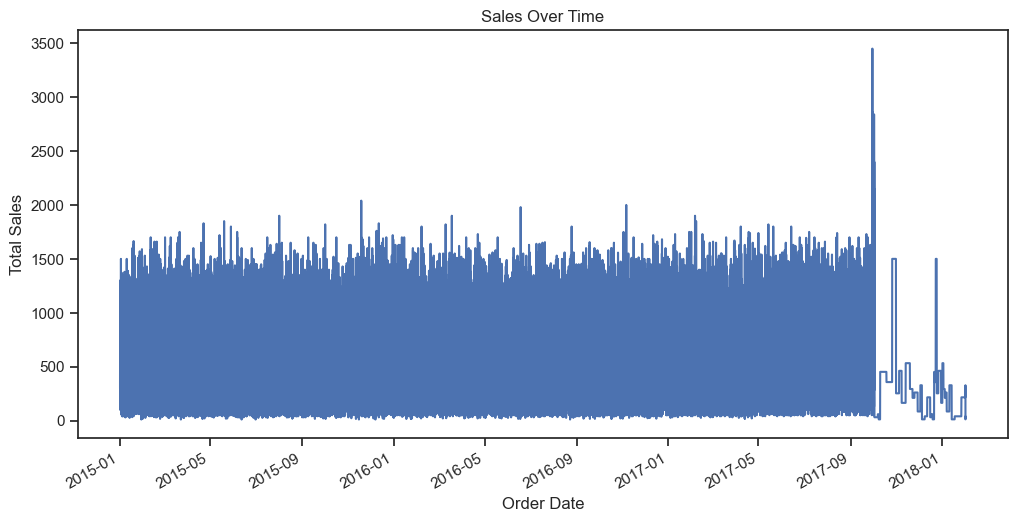

In [64]:
import matplotlib.pyplot as plt

# Group by date and sum the Sales to plot the time series
df_timeseries = df_timeseries_models_features.copy()
df_timeseries['Sales'] = df['Sales']  # Sales is the target variable

# Aggregate Sales by 'order date (DateOrders)'
df_timeseries_agg = df_timeseries.groupby('order date (DateOrders)')['Sales'].sum()

# Plot the time series
plt.figure(figsize=(12, 6))
df_timeseries_agg.plot(title='Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.show()


#### 4. Check for Stationarity

In [65]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_test = adfuller(df_timeseries_agg)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
for key, value in adf_test[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -11.25233342306032
p-value: 1.699895238895454e-20
Critical Value (1%): -3.4304495502511467
Critical Value (5%): -2.86158399939813
Critical Value (10%): -2.566793419384098


#### 5. Seasonality and Trend Detection

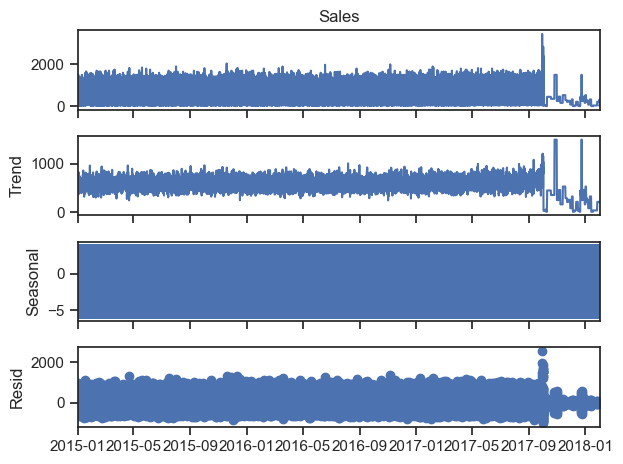

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df_timeseries_agg, model='additive', period=12)  # Adjust the period based on frequency

# Plot the decomposition
decomposition.plot()
plt.show()


#### - Analyzing the target variable 'Sales'

#### a. Visual Inspection of Sales

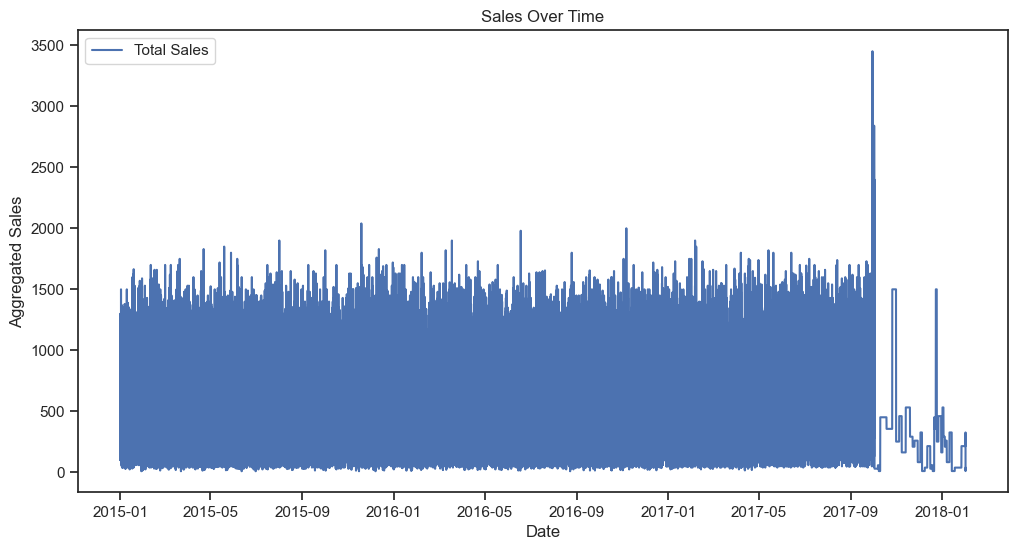

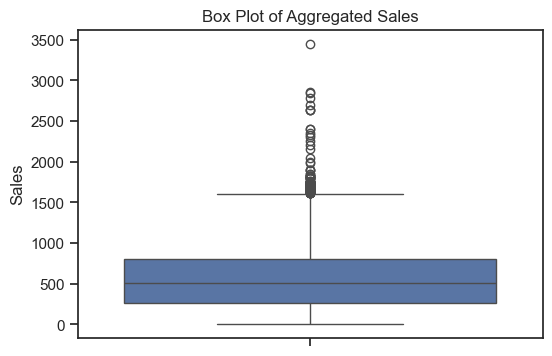

In [67]:
import matplotlib.pyplot as plt

# Plotting the time series of aggregated Sales
plt.figure(figsize=(12, 6))
plt.plot(df_timeseries_agg, label='Total Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Aggregated Sales')
plt.legend()
plt.show()

# To identify potential outliers visually, a boxplot can be useful
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(df_timeseries_agg)
plt.title('Box Plot of Aggregated Sales')
plt.show()


#### b. Statistical Test for Outliers in Sales

In [68]:
from scipy import stats
import numpy as np

# Calculate the Z-scores of aggregated Sales
z_scores = np.abs(stats.zscore(df_timeseries_agg))
threshold = 3  # commonly used threshold for identifying outliers
outliers_sales = df_timeseries_agg[z_scores > threshold]

print("Outliers based on Z-scores:")
print(outliers_sales)


Outliers based on Z-scores:
order date (DateOrders)
2015-01-19 02:46:00    1664.900040
2015-01-19 08:01:00    1629.790031
2015-02-10 20:57:00    1699.900040
2015-02-15 21:29:00    1659.860046
2015-02-16 05:11:00    1639.890045
2015-02-18 21:39:00    1659.860046
2015-03-02 00:15:00    1699.850021
2015-03-09 14:26:00    1699.880051
2015-03-18 13:12:00    1649.910034
2015-03-19 08:07:00    1699.910050
2015-03-21 10:34:00    1749.860046
2015-04-19 01:15:00    1649.830006
2015-04-22 08:46:00    1829.860031
2015-05-13 14:10:00    1719.900047
2015-05-19 18:01:00    1849.900024
2015-05-28 20:17:00    1799.890045
2015-06-06 02:56:00    1699.790024
2015-06-06 03:59:00    1749.800034
2015-07-16 06:01:00    1699.880051
2015-07-20 10:55:00    1629.900040
2015-07-28 18:37:00    1639.830017
2015-08-01 05:18:00    1899.900055
2015-08-04 15:59:00    1649.800034
2015-08-16 10:43:00    1649.800034
2015-09-08 20:19:00    1699.910050
2015-09-15 18:23:00    1649.820023
2015-09-18 22:24:00    1629.880051
201

#### - Correlation and Causation

#### a. Correlation Matrix

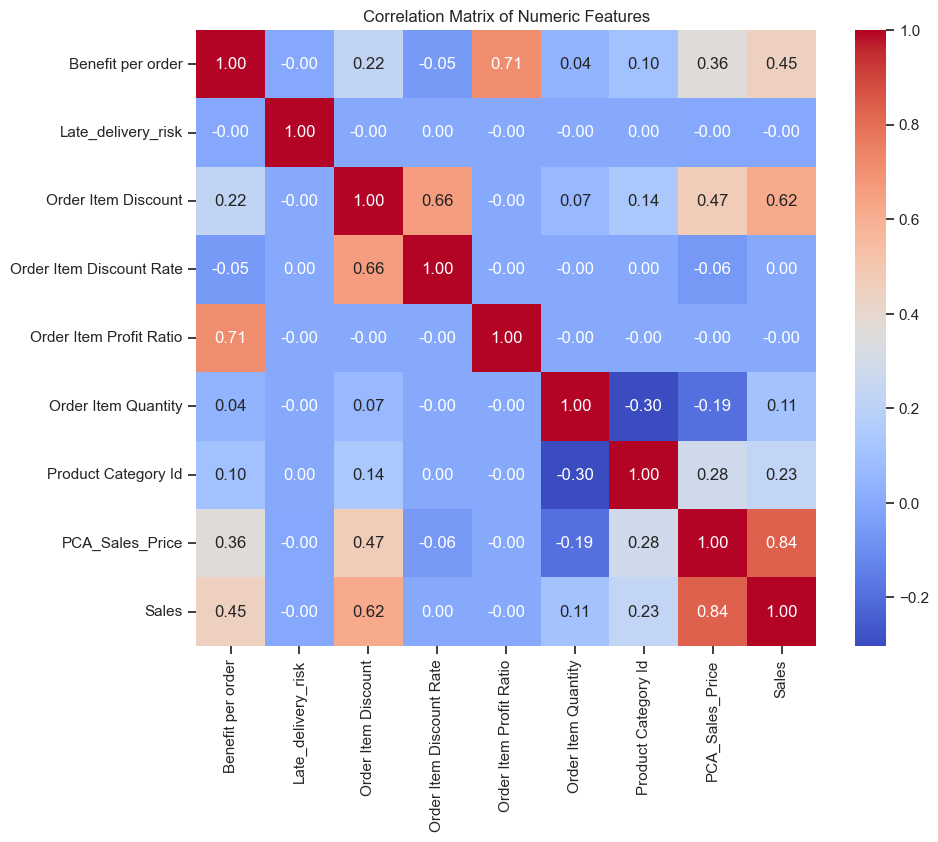

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Merge the Sales data back to the features DataFrame
df_timeseries_models = pd.DataFrame()
df_timeseries_models = df_timeseries_models_features.copy()
df_timeseries_models['Sales'] = df['Sales']

# Select only numeric columns for correlation
numeric_cols = df_timeseries_models.select_dtypes(include=[np.number])

# Calculate the correlation matrix on numeric columns only
correlation_matrix = numeric_cols.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


#### b. Scatter Plots for Detailed Relationship Visualization

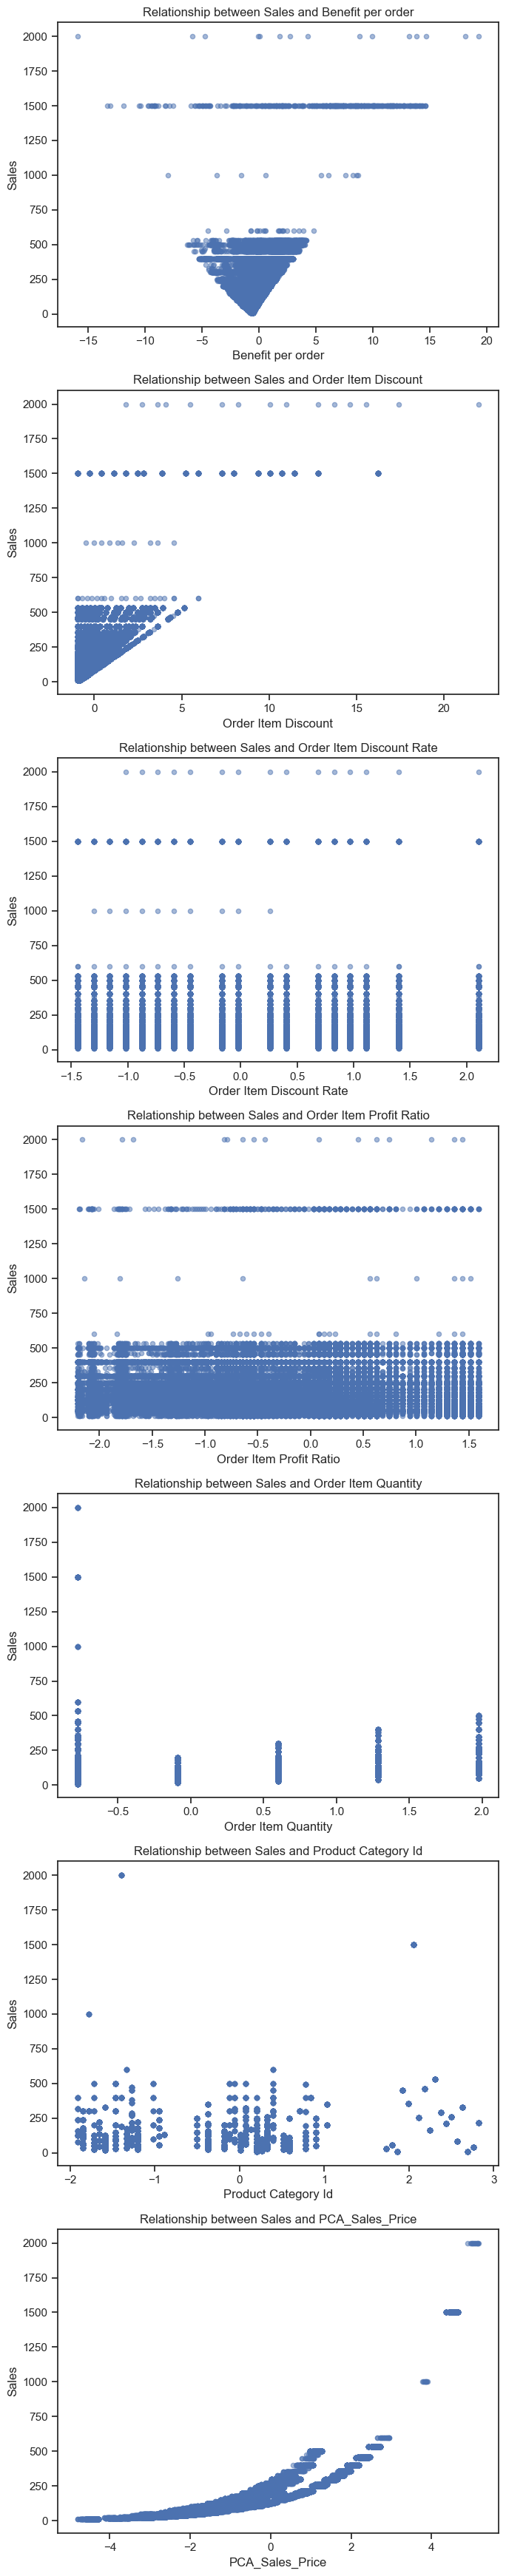

In [70]:
# List of potential exogenous variables you are interested in
variables_of_interest = ['Benefit per order', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Profit Ratio','Order Item Quantity','Product Category Id','PCA_Sales_Price']  # Add your variable names

# Plotting scatter plots between Sales and each variable
fig, axes = plt.subplots(nrows=len(variables_of_interest), figsize=(7, 5 * len(variables_of_interest)))
for i, var in enumerate(variables_of_interest):
    df_timeseries_models.plot(kind='scatter', x=var, y='Sales', ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Relationship between Sales and {var}')
plt.tight_layout()
plt.show()


#### - Managing outliers in Sales

In [71]:
import numpy as np

# Merge the Sales data back to the features DataFrame
df_timeseries_models = pd.DataFrame()
df_timeseries_models = df_timeseries_models_features.copy()
df_timeseries_models['Sales'] = df['Sales']

# Apply log transformation and replace negative or zero values with NaN
df_timeseries_models['Log_Sales'] = df_timeseries_models['Sales'].apply(lambda x: np.log(x) if x > 0 else np.nan)


#### Rechecking after transformation

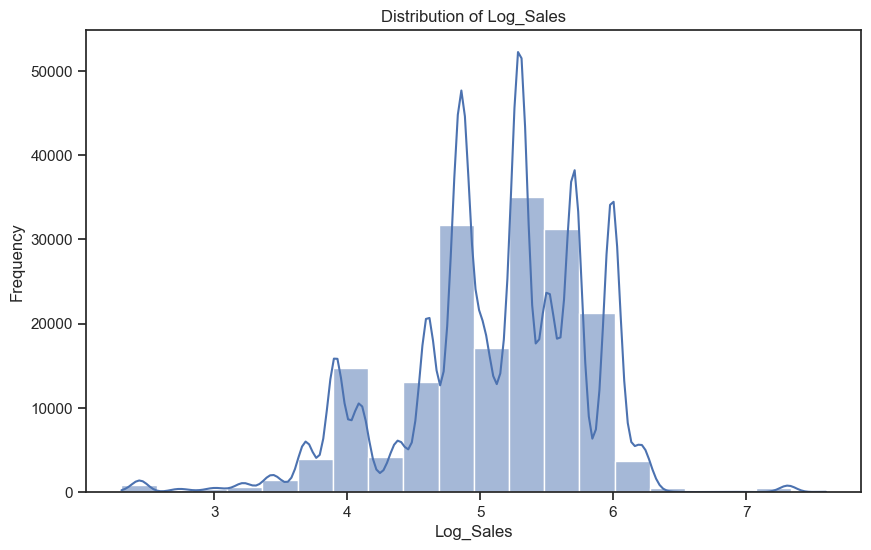

In [72]:
# Check the distribution of Log_Sales
plt.figure(figsize=(10, 6))
sns.histplot(df_timeseries_models['Log_Sales'].dropna(), bins=20, kde=True)
plt.title('Distribution of Log_Sales')
plt.xlabel('Log_Sales')
plt.ylabel('Frequency')
plt.show()

Interpretation:

Multi-modal nature: Since the data is not normally distributed and shows multiple modes, it might imply that different segments of the dataset behave differently. For example, different categories of products or different time periods might be influencing the variation in sales.

Transformation and Modeling: When modeling this data or applying further statistical analysis, the non-normal, multi-modal nature of the distribution should be considered. 
Further Analysis Suggestions:

Cluster Analysis: Consider performing a cluster analysis or using segmentation techniques to identify what differentiates the groups corresponding to each peak.

In [73]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import zscore


# Identify outliers based on z-score of Log_Sales
df_timeseries_models['Log_Sales_Z'] = zscore(df_timeseries_models['Log_Sales'].fillna(df_timeseries_models['Log_Sales'].mean()))
outliers_log_sales = df_timeseries_models[np.abs(df_timeseries_models['Log_Sales_Z']) > 3]
outliers_selected = outliers_log_sales[['Sales', 'Log_Sales', 'order date (DateOrders)']]
print("Outliers based on z-score of Log_Sales:")
print(outliers_selected)

Outliers based on z-score of Log_Sales:
             Sales  Log_Sales order date (DateOrders)
152     1500.00000   7.313220     2017-10-29 12:55:00
155     1500.00000   7.313220     2017-10-30 01:10:00
160     1500.00000   7.313220     2017-10-26 14:51:00
172     1500.00000   7.313220     2017-10-26 18:21:00
1353    1500.00000   7.313220     2017-10-27 19:55:00
1370    1500.00000   7.313220     2017-10-29 17:07:00
1375    1500.00000   7.313220     2017-10-29 16:25:00
1504      19.99000   2.995232     2016-11-28 03:24:00
1508      19.99000   2.995232     2015-08-31 13:19:00
1590      11.29000   2.423917     2017-10-08 09:16:00
1591      11.29000   2.423917     2017-10-08 15:13:00
1594    1500.00000   7.313220     2017-10-30 10:17:00
2348      15.99000   2.771964     2016-08-27 03:42:00
2353      15.99000   2.771964     2015-12-31 21:12:00
2358      19.99000   2.995232     2016-10-22 09:56:00
2361      19.99000   2.995232     2016-01-14 02:16:00
2362      15.99000   2.771964     2015-12-

In [74]:
nan_count_log_sales = df_timeseries_models['Log_Sales'].isna().sum()
print(nan_count_log_sales)

0


Correlation matrix:
                          Benefit per order  Order Item Discount  Order Item Discount Rate  Order Item Profit Ratio  Order Item Quantity  Product Category Id  PCA_Sales_Price  Log_Sales
Benefit per order                  1.000000             0.224566                 -0.053448                 0.711889             0.038490             0.102760         0.360119   0.368538
Order Item Discount                0.224566             1.000000                  0.659955                -0.001232             0.065379             0.140180         0.472660   0.536048
Order Item Discount Rate          -0.053448             0.659955                  1.000000                -0.002141            -0.000028             0.000572        -0.063209   0.000129
Order Item Profit Ratio            0.711889            -0.001232                 -0.002141                 1.000000            -0.000072            -0.001440        -0.001025  -0.001218
Order Item Quantity                0.038490       

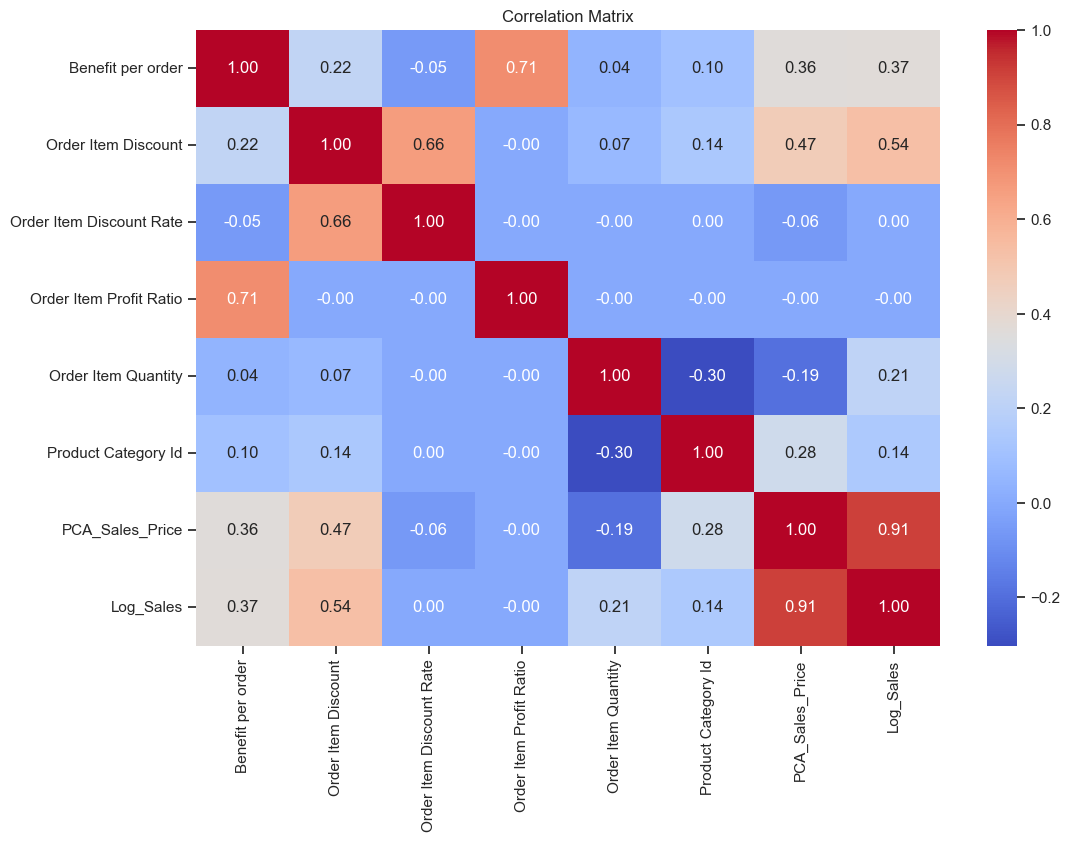

In [75]:
# Correlation matrix of specified columns
columns_of_interest = [
    'Benefit per order', 'Order Item Discount', 'Order Item Discount Rate',
    'Order Item Profit Ratio', 'Order Item Quantity', 'Product Category Id',
    'PCA_Sales_Price', 'Log_Sales'
]
correlation_matrix = df_timeseries_models[columns_of_interest].corr()
print("Correlation matrix:")
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Interpretation:
Strong Correlations:

PCA_Sales_Price and Log_Sales have a very high correlation of 0.913. This suggests that as the PCA-adjusted sales price increases, the log-transformed sales also tend to increase substantially. This could indicate a strong direct influence of sales price on sales volume when adjusted for principal component analysis.

Order Item Discount and Log_Sales have a substantial correlation of 0.536. Higher discounts seem to be associated with higher sales, which could suggest that discounts drive sales volumes.

Moderate Correlations:

Benefit per order and Order Item Profit Ratio are correlated at 0.712, indicating a strong linkage between the benefits obtained per order and the profit ratio. This might suggest that orders with higher benefits tend to also have higher profit ratios.

Order Item Discount and Order Item Discount Rate have a strong correlation of 0.660, indicating that as the discount rate increases, the absolute discount value also increases.

Order Item Discount and PCA_Sales_Price share a correlation of 0.473, suggesting that higher discounts might be offered on items with higher PCA-adjusted sales prices.

 Moderate correlations across different variables suggest that different product categories and order characteristics might influence sales differently. This might warrant segment-specific strategies to optimize benefits and discounts.

 Segmented Analysis: Given the different behavior of various categories and profit ratios, it might be beneficial to perform segmented analyses, possibly by product category, to tailor strategies appropriately.

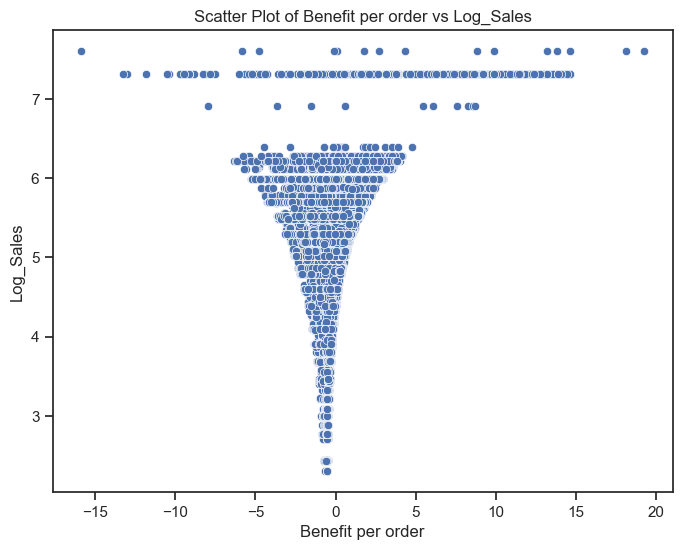

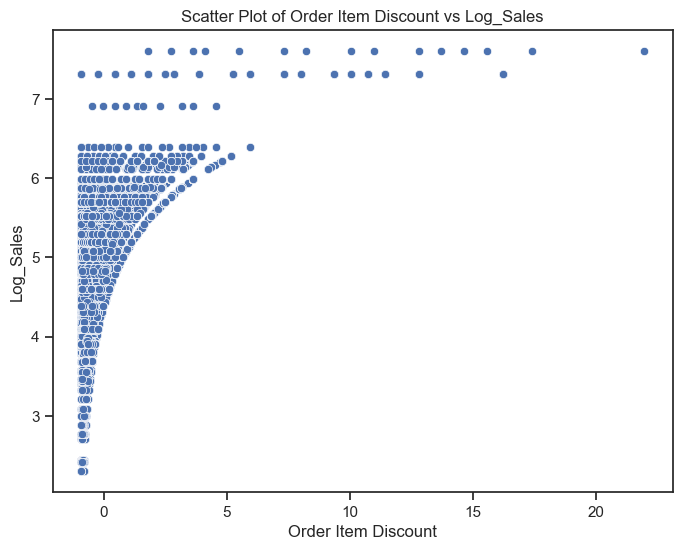

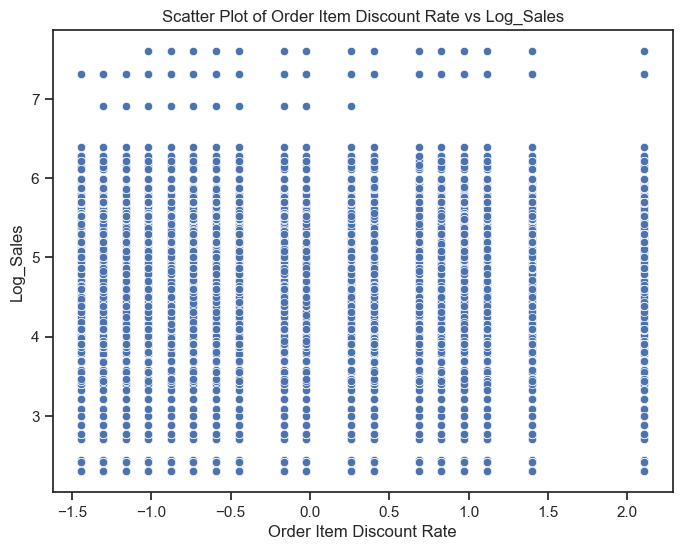

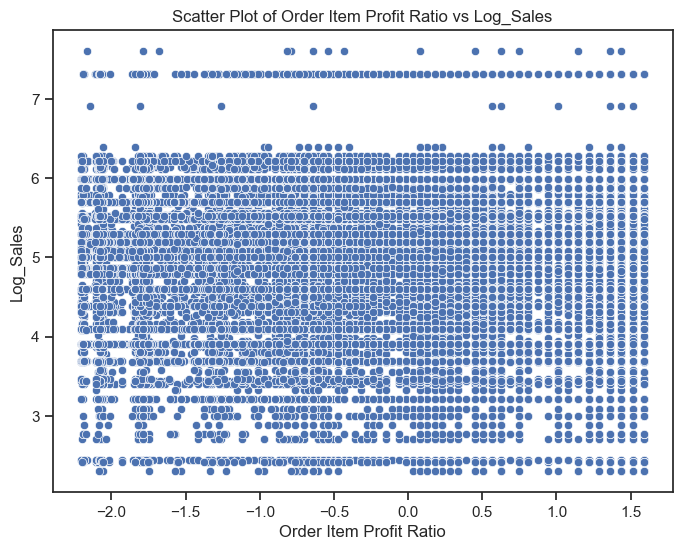

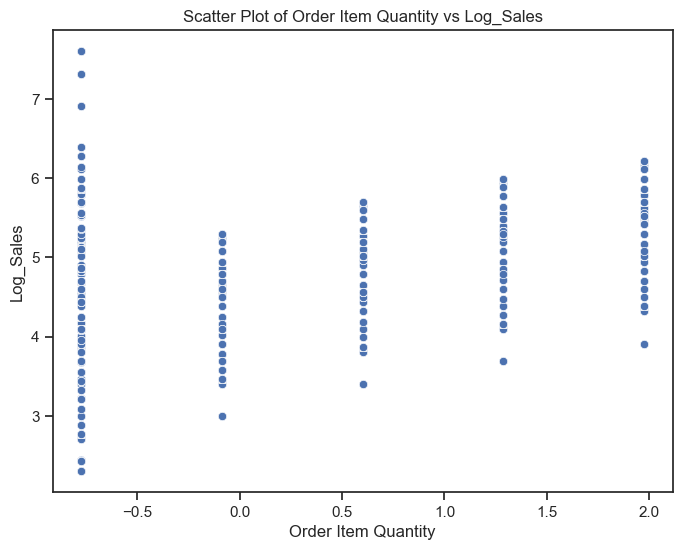

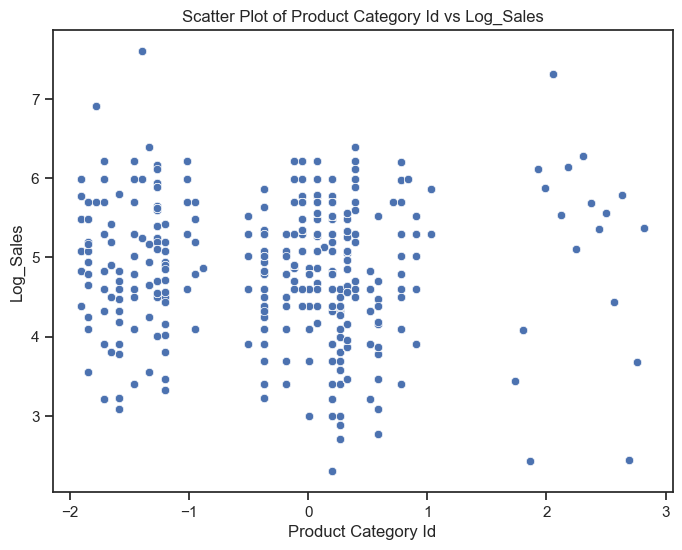

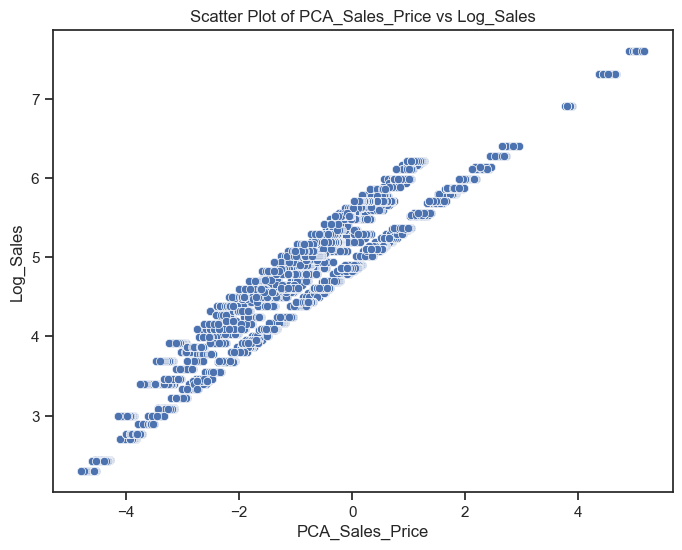

In [76]:
# Scatter plot of specified columns with Log_Sales
for column in columns_of_interest[:-1]:  # Exclude 'Log_Sales' itself
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_timeseries_models, x=column, y='Log_Sales')
    plt.title(f'Scatter Plot of {column} vs Log_Sales')
    plt.xlabel(column)
    plt.ylabel('Log_Sales')
    plt.show()

Interpretation:

Key Variables of Interest:

PCA_Sales_Price: With a high correlation of 0.913 with Log_Sales, PCA_Sales_Price is a critical predictor. This suggests a strong direct relationship between sales prices adjusted for principal components and sales volumes.

Order Item Discount: Shows a substantial correlation of 0.536 with Log_Sales. This indicates that discounts can significantly influence sales, and adjusting discounts might be an effective way to manage sales volumes over time.

Recommendations for Time Series Analysis:

Feature Engineering:

Lag Variables: Given the strong relationships observed, consider creating lagged variables of PCA_Sales_Price and Order Item Discount to capture temporal dynamics that influence Log_Sales.

Rolling Averages: Utilize rolling averages of prices and discounts to smooth out short-term fluctuations and capture longer-term trends.

Seasonal Adjustments: If there are seasonal patterns in Log_Sales, which might be indicated by fluctuations corresponding to specific times (e.g., holidays, promotional periods), incorporating seasonal dummies or using seasonal adjustment techniques would be beneficial.

Model Selection:

ARIMA/SARIMA Models: Given the time series nature of sales data, ARIMA (Autoregressive Integrated Moving Average) models, especially SARIMA (Seasonal ARIMA) if seasonality is present, would be suitable for modeling Log_Sales. These models can effectively incorporate the lagged effects of sales, price, and discount.

Regression with ARMA Errors: To directly incorporate the effects of variables like PCA_Sales_Price and Order Item Discount into a time series model, consider using a regression model with ARMA errors.

Variable Importance and Interaction:

Explore interactions between PCA_Sales_Price and Order Item Discount to assess if the impact of discounts on sales is moderated by the price levels. This can reveal more nuanced insights into pricing strategies.

Anomaly Detection:

Given the presence of outliers as seen in the scatter plots, integrating anomaly detection before modeling could help in identifying and handling extreme values which might distort model estimations.

In [77]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


# Merge the Sales data back to the features DataFrame
df_timeseries_models = pd.DataFrame()
df_timeseries_models = df_timeseries_models_features.copy()
df_timeseries_models['Sales'] = df['Sales']

# Group by 'DateOrders' and sum 'Sales' to remove duplicate dates
df_timeseries_models = df_timeseries_models.groupby('order date (DateOrders)')['Sales'].sum().reset_index()

aggregated_sales =df_timeseries_models.copy()

# Apply log transformation and replace negative or zero values with NaN
aggregated_sales['Log_Sales'] = df_timeseries_models['Sales'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Sort the DataFrame by the date index to ensure monotonicity
aggregated_sales = aggregated_sales.sort_values('order date (DateOrders)')

# Set the date column as the index for time series analysis
aggregated_sales = aggregated_sales.set_index('order date (DateOrders)')


# Sort the DataFrame by the date index to ensure monotonicity
df_timeseries_models = df_timeseries_models.sort_values('order date (DateOrders)')

# Set the date column as the index for time series analysis
df_timeseries_models = df_timeseries_models.set_index('order date (DateOrders)')



In [78]:
# Ensure the index is a DatetimeIndex and set a frequency

aggregated_sales = aggregated_sales.asfreq('d')
aggregated_sales = aggregated_sales.fillna(method='ffill')
aggregated_sales = aggregated_sales.fillna(method='bfill')

df_timeseries_models = df_timeseries_models.asfreq('d')  # Adjust frequency as needed
df_timeseries_models = df_timeseries_models.fillna(method='ffill')
df_timeseries_models = df_timeseries_models.fillna(method='bfill')



C:\Users\CZ0068\AppData\Local\Temp\ipykernel_16468\3085203404.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_sales = aggregated_sales.fillna(method='ffill')
C:\Users\CZ0068\AppData\Local\Temp\ipykernel_16468\3085203404.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_sales = aggregated_sales.fillna(method='bfill')
C:\Users\CZ0068\AppData\Local\Temp\ipykernel_16468\3085203404.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_timeseries_models = df_timeseries_models.fillna(method='ffill')
C:\Users\CZ0068\AppData\Local\Temp\ipykernel_16468\3085203404.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() in

In [79]:
# Optionally check if any NaN remains
print(df_timeseries_models.isna().sum())

Sales    0
dtype: int64


In [80]:
# Optionally check if any NaN remains
print(aggregated_sales.isna().sum())

Sales        0
Log_Sales    0
dtype: int64


In [81]:
df_timeseries_models.shape

(1127, 1)

In [82]:
aggregated_sales.shape

(1127, 2)

In [83]:
print("Start date:", df_timeseries_models.index.min())
print("End date:", df_timeseries_models.index.max())


Start date: 2015-01-01 00:00:00
End date: 2018-01-31 00:00:00


In [84]:
date_range = pd.date_range(start=df_timeseries_models.index.min(), end=df_timeseries_models.index.max())
print("Expected number of days:", len(date_range))
print("Actual rows in DataFrame:", len(df_timeseries_models))


Expected number of days: 1127
Actual rows in DataFrame: 1127


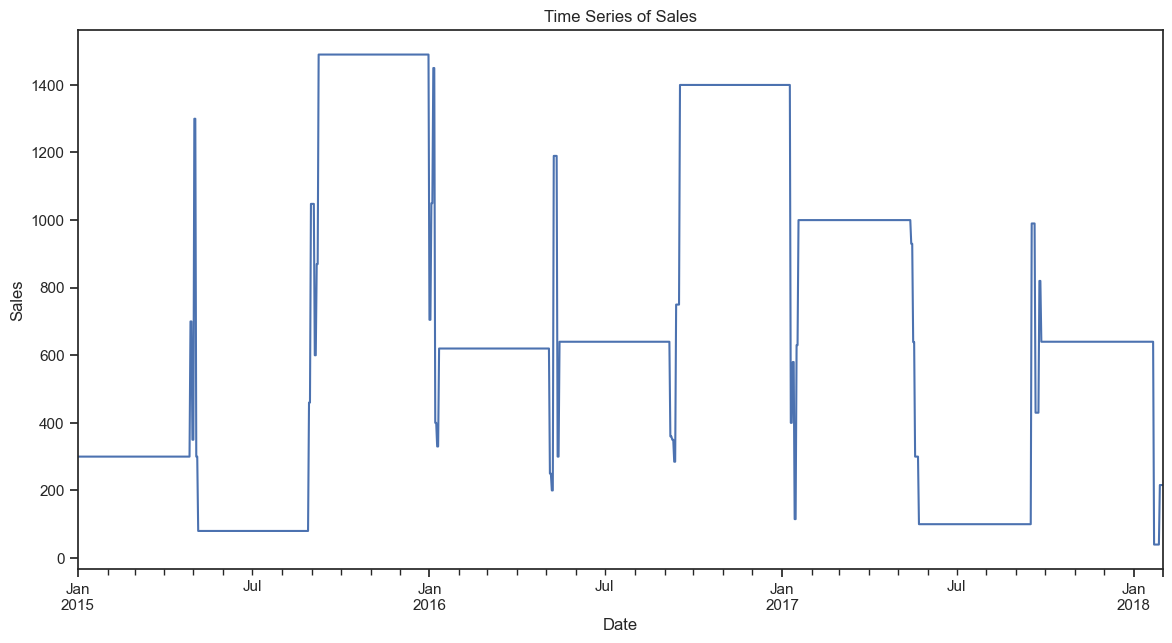

In [85]:
import matplotlib.pyplot as plt

# Line plot for trend analysis
df_timeseries_models['Sales'].plot(figsize=(14, 7))
plt.title('Time Series of Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


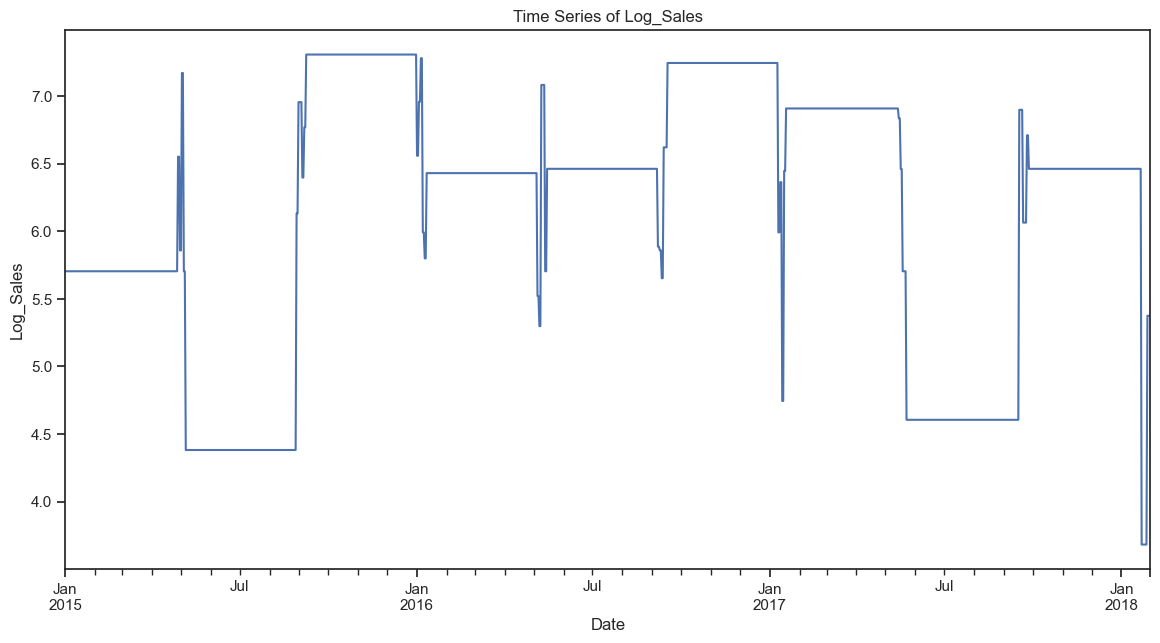

In [86]:
import matplotlib.pyplot as plt

# Line plot for trend analysis
aggregated_sales['Log_Sales'].plot(figsize=(14, 7))
plt.title('Time Series of Log_Sales')
plt.xlabel('Date')
plt.ylabel('Log_Sales')
plt.show()

Interpretation of the Plot

Seasonal Patterns: The spikes and sharp declines suggest a possible seasonal influence on sales. For example, if this is retail data, these spikes might align with holiday seasons or sales events, followed by quieter periods.

Sharp Drops and Recoveries: The abrupt falls to near-zero levels followed by quick recoveries could indicate periods when sales activities are halted—possibly due to external factors like stockouts, business closures for holidays, or system reporting issues.

Yearly Trends: Each year appears to show similar patterns, which strengthens the case for significant seasonal effects or annual sales cycles.

Recommendations for Analysis:

Seasonal Decomposition: Conduct a seasonal decomposition to confirm and quantify the seasonal effects observed in the plot. This can help in understanding the magnitude and timing of seasonal variations.

Stationarity Check: Check for stationarity using the Augmented Dickey-Fuller test or KPSS test to determine if the series needs differencing to make it stationary, which is a requirement for ARIMA modeling.

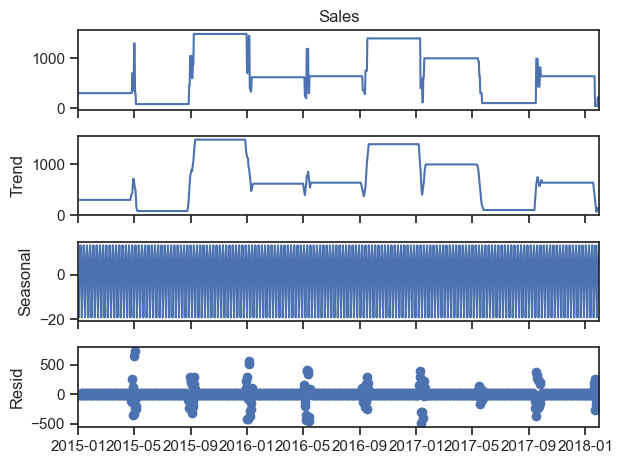

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_timeseries_models['Sales'], model='additive')
decomposition.plot()
plt.show()


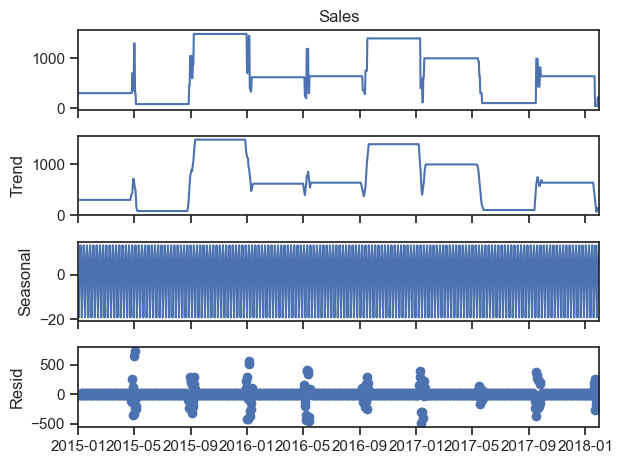

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(aggregated_sales['Sales'], model='additive')
decomposition.plot()
plt.show()

In [89]:
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(df_timeseries_models['Sales'])
print('ADF Statistic:', test_result[0])
print('p-value:', test_result[1])


ADF Statistic: -2.397867688408506
p-value: 0.14233914255793756


In [90]:
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(aggregated_sales['Log_Sales'])
print('ADF Statistic:', test_result[0])
print('p-value:', test_result[1])


ADF Statistic: -2.413577348044455
p-value: 0.13794091484242532


Interpretation of Seasonal Decomposition:

The decomposition into trend, seasonal, and residual components shows:

Sales and Trend: Both the original sales and the trend component exhibit sharp rises and drops. The trend component, however, smooths out some of the more abrupt changes, indicating that these could be due to regular fluctuations or outliers.

Periods of flat, near-zero sales suggest either off-seasons, data collection issues, or business closures.

Seasonal: The seasonal component shows a very high frequency of fluctuations within each year, indicating significant within-year variability that repeats annually. This rapid oscillation suggests the presence of micro-seasonal effects (potentially daily or weekly) that are consistent over time.

Residuals: The residuals, which represent the portion of the sales not explained by the trend or seasonality, appear mostly random and centered around zero. However, there are a few large spikes, which could represent unmodeled influences or anomalies in the data.

Stationarity Check:

ADF Test Results:

ADF Statistic: -2.397867688408506

p-value: 0.14233914255793756

The p-value is greater than the common threshold of 0.05, indicating that the series is not stationary. This means there is a unit root present in the series, implying that the series may have properties such as trend or seasonality that depend on time.

Recommendations:

Differencing:

Since the data is not stationary, we consider differencing the series to remove trends and/or seasonal effects. Starting with first differencing and check stationarity again. If the data remains non-stationary, consider seasonal differencing given the clear seasonal pattern observed.

In [91]:
# First differencing
df_timeseries_models['Sales_diff'] = df_timeseries_models['Sales'].diff().dropna()

# Check stationarity again
result_diff = adfuller(df_timeseries_models['Sales_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])


ADF Statistic: -22.741892950080352
p-value: 0.0


In [92]:
# First differencing
aggregated_sales['Log_Sales_diff'] = aggregated_sales['Log_Sales'].diff().dropna()

# Check stationarity again
result_diff = adfuller(aggregated_sales['Log_Sales_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])


ADF Statistic: -17.070496061798515
p-value: 7.831611584468338e-30


Interpretation of ADF Test Results After Differencing:

Strong Rejection of the Null Hypothesis:

The ADF statistic is significantly below any typical critical value, and the p-value is effectively zero. This strongly suggests that the differenced series is stationary.
Rejecting the null hypothesis implies there is no unit root in the differenced series, and the series does not depend on time in a way that would prevent reliable predictions.

Implications for Time Series Modeling:  Achieving stationarity is a crucial prerequisite for many time series forecasting methods, including ARIMA and SARIMA models. Stationarity implies that the properties of the series such as mean and variance do not change over time, making the series more predictable.

Next Steps in Modeling: Given the stationarity of the differenced data, we can proceed with confidence to develop time series forecasting models. 

Model Specification: We can specify a SARIMA model without needing further differencing. The parameters for the SARIMA model can now focus more on the MA (Moving Average) and AR (Autoregressive) parts, as the differencing component has been addressed.

The seasonal elements of the SARIMA model should be determined based on the frequency and amplitude of seasonal patterns observed earlier in the seasonal decomposition.

Fit SARIMA Model:

Given the presence of clear seasonal patterns previously identified, fit a SARIMA model that accounts for both the non-seasonal and seasonal aspects.


In [93]:
import pmdarima as pm

# Assuming the seasonal period is 12 (e.g., monthly data with yearly seasonality)
sarima_model = pm.auto_arima(df_timeseries_models['Sales'], 
                             seasonal=True, m=12, 
                             d=1, D=1,   # non-seasonal and seasonal differencing
                             start_p=0, start_q=0, max_p=3, max_q=3,
                             start_P=0, start_Q=0, max_P=2, max_Q=2,
                             trace=True, error_action='ignore', 
                             suppress_warnings=True, stepwise=True)

print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14240.578, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13933.695, Time=1.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14242.578, Time=0.02 sec


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13810.354, Time=3.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=79.94 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=13808.354, Time=3.35 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=13931.695, Time=0.81 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=69.32 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=13810.354, Time=4.36 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=85.64 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=13810.342, Time=72.31 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 326.571 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1127
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -69

The results from  SARIMA model fitting process and the output from the final selected model indicate that we have a model that fits the data relatively well based on the AIC criterion and the significance of the coefficients.

1. Model Evaluation
The best model obtained is SARIMAX(0, 1, 0)x(2, 1, 0, 12), which indicates:

No autoregressive (AR) or moving average (MA) components for the non-seasonal part.

Two autoregressive components for the seasonal part with a period of 12 (this would be yearly seasonality).

Given this model, we should:

Review Diagnostic Plots: Check the residuals of SARIMA model to ensure that they resemble white noise (i.e., normally distributed, mean zero, constant variance, and no autocorrelation).

In [93]:
import pmdarima as pm

# Assuming the seasonal period is 12 (e.g., monthly data with yearly seasonality)
sarima_model_log_sales = pm.auto_arima(aggregated_sales['Log_Sales'], 
                             seasonal=True, m=12, 
                             d=1, D=1,   # non-seasonal and seasonal differencing
                             start_p=0, start_q=0, max_p=3, max_q=3,
                             start_P=0, start_Q=0, max_P=2, max_Q=2,
                             trace=True, error_action='ignore', 
                             suppress_warnings=True, stepwise=True)

print(sarima_model_log_sales.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=323.353, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=54.542, Time=0.88 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=325.353, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-50.403, Time=4.10 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=66.91 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.66 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-52.403, Time=2.98 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=52.542, Time=0.61 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=55.80 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.71 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-50.403, Time=4.16 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-48.403, Time=4.74 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-50.423, Time=55.21 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Tota

Comparing the two SARIMA models—before and after the log transformation of Sales—provides valuable insights into how transformations can significantly impact the model fit and its diagnostics. 

Comparison of SARIMA Model Fits

1. Model Performance Metrics (AIC):

Pre-Transformation: The best AIC obtained was 13808.354 with the model SARIMAX(0,1,0)x(2,1,0)[12].

Post-Log Transformation: The best AIC was significantly lower at -52.403 with the same model configuration SARIMAX(0,1,0)x(2,1,0)[12].

Interpretation:

The dramatic decrease in AIC post-transformation suggests that the log transformation helped in stabilizing the variance and making the model more efficient. Lower AIC values typically indicate a better model fit to the data, considering both the goodness of fit and the complexity of the model.

2. Residual Analysis:

Pre-Transformation: The residuals were non-normally distributed with significant kurtosis (as indicated by the high Jarque-Bera statistic) and possible heteroskedasticity (uneven variance across time).

Post-Log Transformation: Residuals still show signs of non-normality but the heteroskedasticity appears to be better managed, as indicated by a lower heteroskedasticity test statistic (H) and a slightly improved distribution in the histogram.

3. Seasonal Components:

In both cases, the seasonal AR components are significant, indicating strong seasonal patterns in the data. The coefficients for these components were very similar in both pre and post-transformation models, suggesting that the seasonal dynamics of the series were preserved even after the transformation.

4. Ljung-Box and Jarque-Bera Test Results:

Pre-Transformation: High JB statistic suggests heavy tails and possibly outliers.

Post-Log Transformation: JB statistic is still high, indicating persistent issues with the tail behavior of the residuals.

Next Steps:

Address Residual Issues:

Although the log transformation improved the model fit (as evidenced by AIC), the residuals still exhibit non-normal behavior. Further transformations or the inclusion of additional terms in the model might be required. 

Consider Box-Cox transformations or adding moving average components to capture any residual autocorrelation not addressed by the seasonal differencing.

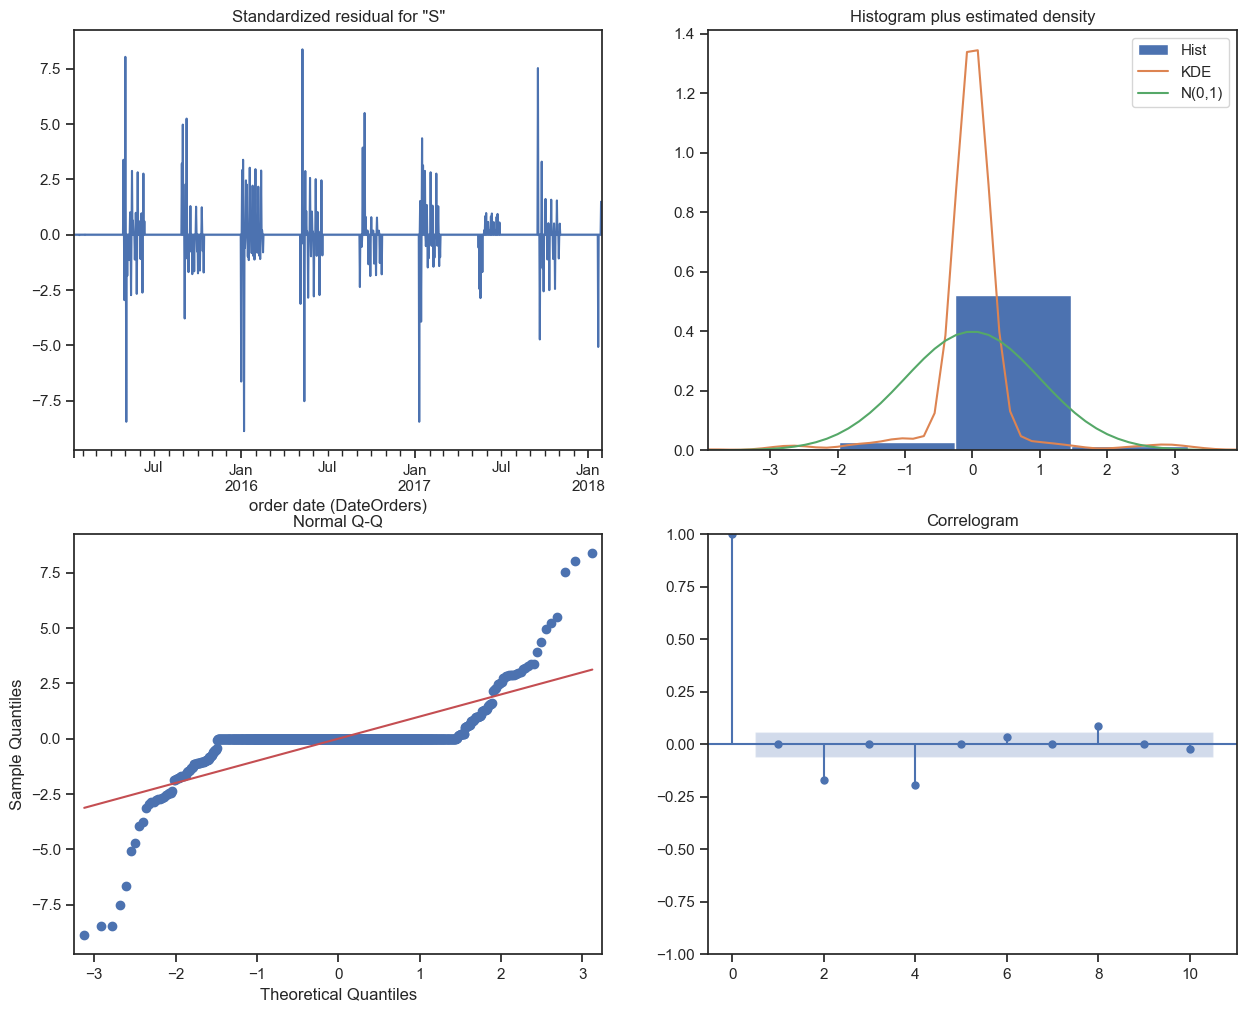

In [95]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit the best SARIMA model
model = sm.tsa.statespace.SARIMAX(df_timeseries_models['Sales'], order=(0, 1, 0), seasonal_order=(2, 1, 0, 12))
results = model.fit()

# Plot the diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()


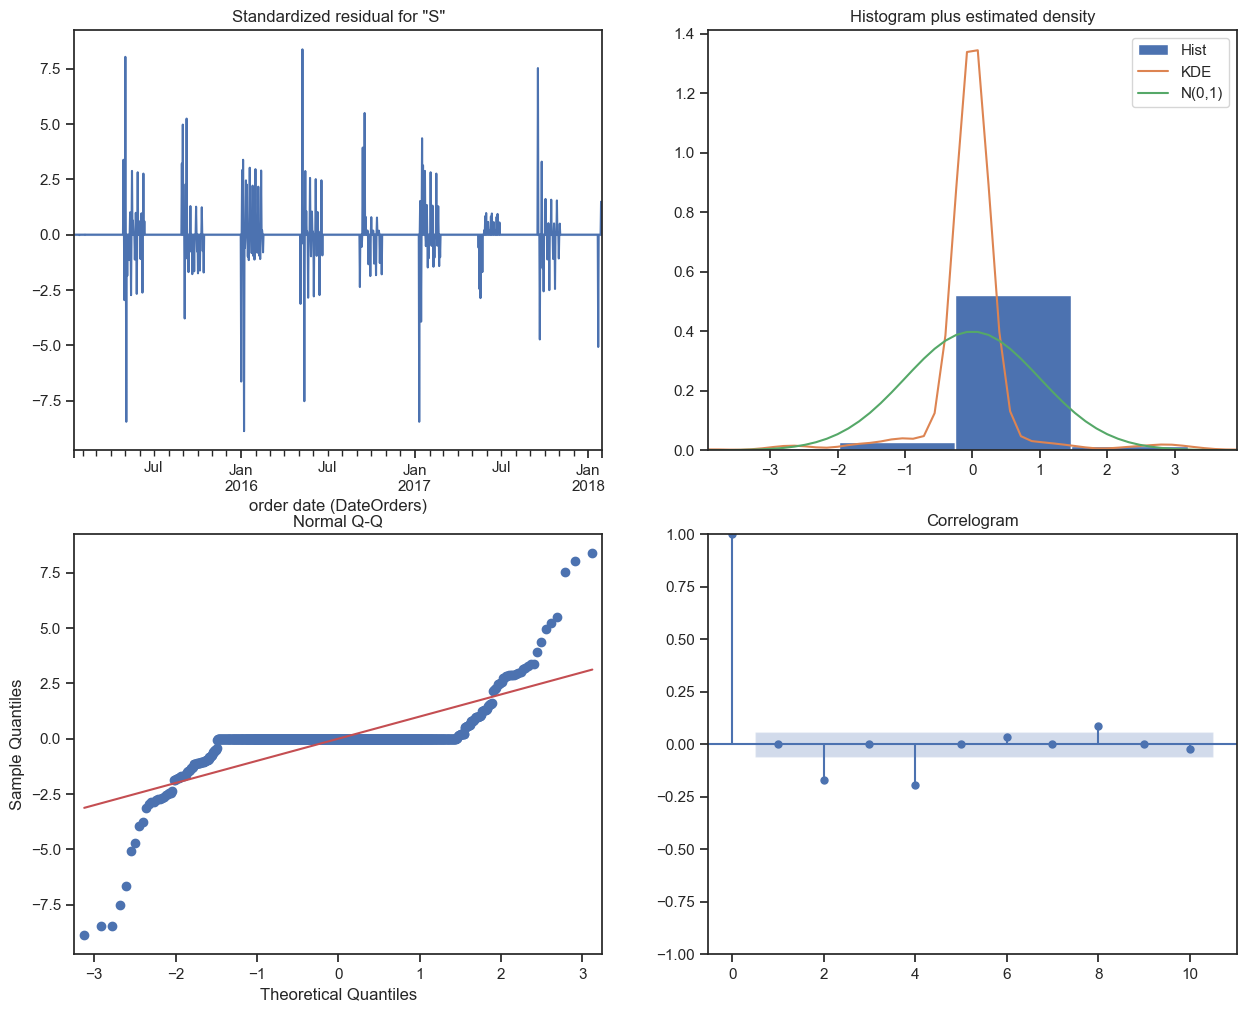

In [96]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit the best SARIMA model
model_log_sales = sm.tsa.statespace.SARIMAX(aggregated_sales['Log_Sales'], order=(0, 1, 0), seasonal_order=(2, 1, 0, 12))
results_log_sales = model.fit()

# Plot the diagnostics
results_log_sales.plot_diagnostics(figsize=(15, 12))
plt.show()


The comparison of the diagnostic plots for both SARIMA models (before and after log transformation) can provide insights into how the transformation influenced the residuals and overall model fit. 

Standardized Residuals Plot:

Both Cases: The plots show residuals fluctuating around zero without clear patterns, which is positive as it indicates no autocorrelation issues. However, there are numerous outliers in both cases, suggesting occasional large deviations from the model predictions.

Histogram and Kernel Density Estimate (KDE) Plot:

Both Cases: The histograms for both models show that the residuals are not normally distributed. The KDE does not align with the green normal distribution curve, particularly in the tails. This indicates that the residuals have heavy tails and are skewed.

Q-Q Plot:

Both Cases: The Q-Q plots in both cases indicate that the residuals deviate from the theoretical quantiles, especially in the tails. This is another indication of non-normality, with the residuals exhibiting heavier tails than would be expected under a normal distribution.

Correlogram (ACF Plot):

Both Cases: The autocorrelation function plots show that the autocorrelations for various lags are mostly within the confidence bounds, suggesting no significant autocorrelation issues. This implies that the models are adequately capturing the temporal dependencies in the data.

Analysis and Interpretation: 

Transformation Impact: The log transformation does not seem to have significantly altered the nature of the residuals in terms of autocorrelation and normality. In both cases, the models handle autocorrelation well, but struggle with the non-normality of residuals.

Residual Outliers: The presence of outliers in both models suggests that there may be extreme values or anomalies in the sales data that the models are not capturing. This could be due to inherent volatility in the data or external shocks not accounted for by the model.

Recommendations:

Alternative Transformations: Since the log transformation did not fully address the issues with residual distribution, consider other transformations, such as Box-Cox or Movigng Average which might better stabilize variance and achieve normality.

Now Trying with Box Cox and Movign Average Transformation of Sales.

Fitted lambda for Box-Cox transformation: 0.5270136564457502


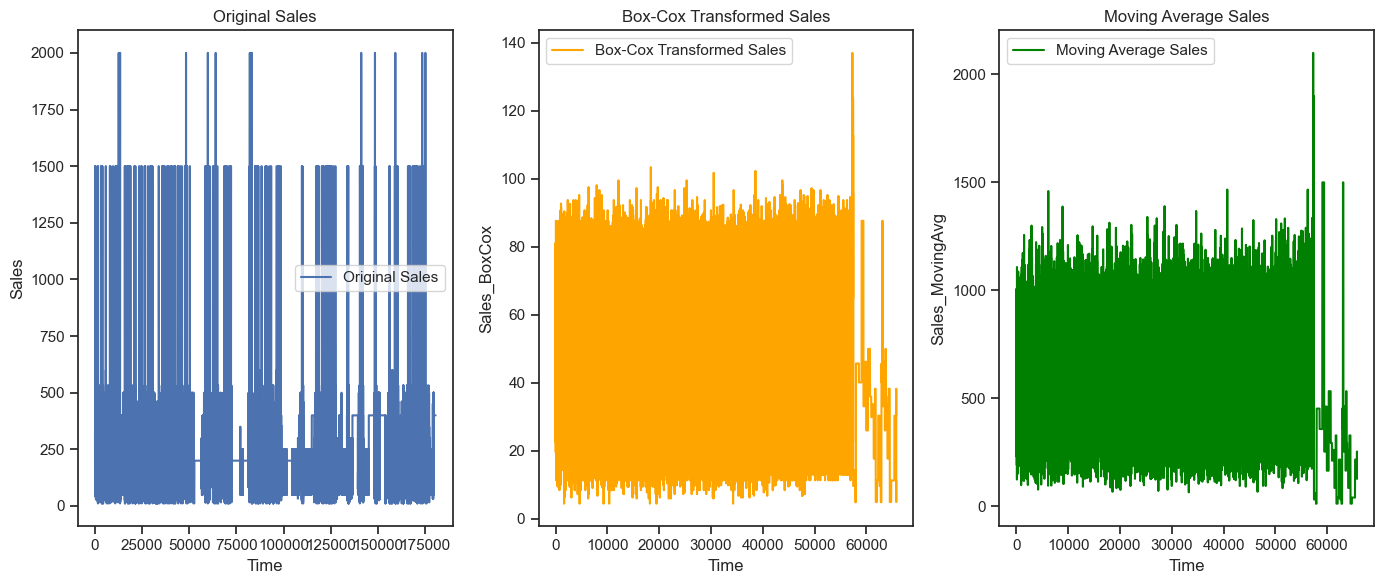

In [128]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt

# Assuming df and df_timeseries_models_features are already defined

# Merge the Sales data back to the features DataFrame
df_timeseries_box_cox = pd.DataFrame()
df_timeseries_box_cox = df_timeseries_models_features.copy()
df_timeseries_box_cox['Sales'] = df['Sales']

df_timeseries_ma = pd.DataFrame()
df_timeseries_ma = df_timeseries_models_features.copy()
df_timeseries_ma['Sales'] = df['Sales']

# Group by 'DateOrders' and sum 'Sales' to remove duplicate dates
df_timeseries_box_cox = df_timeseries_box_cox.groupby('order date (DateOrders)')['Sales'].sum().reset_index()

# Group by 'DateOrders' and sum 'Sales' to remove duplicate dates
df_timeseries_ma = df_timeseries_ma.groupby('order date (DateOrders)')['Sales'].sum().reset_index()


# Apply Box-Cox transformation to the Sales data in df_timeseries_box_cox
df_timeseries_box_cox['Sales_BoxCox'], fitted_lambda = boxcox(df_timeseries_box_cox['Sales'] + 1e-6)

# Display the lambda used for the Box-Cox transformation
print(f"Fitted lambda for Box-Cox transformation: {fitted_lambda}")

# Apply Moving Average transformation to the Sales data in df_timeseries_ma
window_size = 3  # Define the window size for the moving average
df_timeseries_ma['Sales_MovingAvg'] = df_timeseries_ma['Sales'].rolling(window=window_size, center=True).mean()

# Drop NaN values resulting from moving average calculation
df_timeseries_ma.dropna(subset=['Sales_MovingAvg'], inplace=True)

# Plotting the original and transformed Sales data
plt.figure(figsize=(14, 6))

# Plot original Sales
plt.subplot(1, 3, 1)
plt.plot(df_timeseries['Sales'], label='Original Sales')
plt.title('Original Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()

# Plot Box-Cox transformed Sales
plt.subplot(1, 3, 2)
plt.plot(df_timeseries_box_cox['Sales_BoxCox'], label='Box-Cox Transformed Sales', color='orange')
plt.title('Box-Cox Transformed Sales')
plt.xlabel('Time')
plt.ylabel('Sales_BoxCox')
plt.legend()

# Plot Moving Average transformed Sales
plt.subplot(1, 3, 3)
plt.plot(df_timeseries_ma['Sales_MovingAvg'], label='Moving Average Sales', color='green')
plt.title('Moving Average Sales')
plt.xlabel('Time')
plt.ylabel('Sales_MovingAvg')
plt.legend()

plt.tight_layout()
plt.show()



Interpretation:

Box-Cox Transformed Sales: The transformed data appears more uniform compared to the original, which is a good sign for certain modeling techniques that assume homoscedasticity (constant variance). The scale difference suggests the transformation was successful in stabilizing variance.

Moving Average Sales: This transformation smoothed out the fluctuations in sales data, which is helpful for identifying underlying trends in the data and reducing noise, making it more suitable for further modeling.

In [129]:
# Sort the DataFrame by the date index to ensure monotonicity
df_timeseries_box_cox = df_timeseries_box_cox.sort_values('order date (DateOrders)')

# Set the date column as the index for time series analysis
df_timeseries_box_cox = df_timeseries_box_cox.set_index('order date (DateOrders)')

In [130]:
# Ensure the index is a DatetimeIndex and set a frequency

df_timeseries_box_cox = df_timeseries_box_cox.asfreq('d')
df_timeseries_box_cox = df_timeseries_box_cox.fillna(method='ffill')
df_timeseries_box_cox = df_timeseries_box_cox.fillna(method='bfill')


C:\Users\CZ0068\AppData\Local\Temp\ipykernel_16468\1304234070.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_timeseries_box_cox = df_timeseries_box_cox.fillna(method='ffill')
C:\Users\CZ0068\AppData\Local\Temp\ipykernel_16468\1304234070.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_timeseries_box_cox = df_timeseries_box_cox.fillna(method='bfill')


In [131]:
# Optionally check if any NaN remains
print(df_timeseries_box_cox.isna().sum())

Sales           0
Sales_BoxCox    0
dtype: int64


In [132]:
df_timeseries_box_cox.shape

(1127, 2)

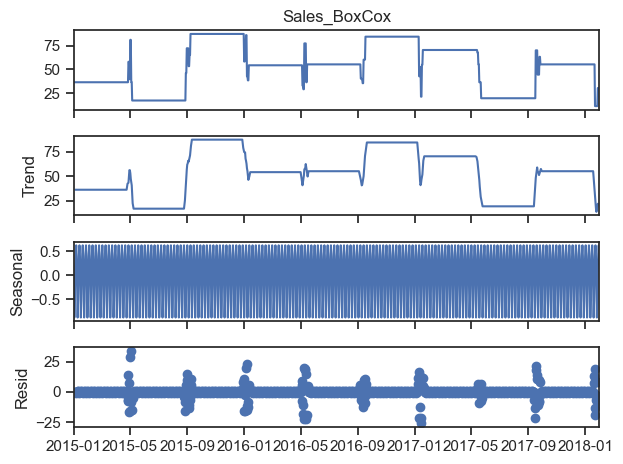

ADF Statistic: -2.3169205084041575
p-value: 0.16656882814891083


In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_timeseries_box_cox['Sales_BoxCox'], model='additive')
decomposition.plot()
plt.show()

from statsmodels.tsa.stattools import adfuller
test_result = adfuller(df_timeseries_box_cox['Sales_BoxCox'])
print('ADF Statistic:', test_result[0])
print('p-value:', test_result[1])

Interpretation:

Stability of Transformations: The Box-Cox transformation helped in stabilizing the variance, making the series more amenable for analysis and modeling.

Significance of Trend and Seasonal Components: Both components are significant, indicating that any forecasting model should account for them to predict future values accurately.

Quality of Model Fit: The randomness of the residuals suggests that the decomposition has effectively captured the underlying patterns in the data, which is crucial for accurate forecasting.

Non-stationarity: The test suggests that the data, even after the Box-Cox transformation, still exhibits non-stationary behavior. This could be due to trends, cyclic patterns not captured by the seasonal adjustment, or other structural changes in the data.

Further Actions:
Differencing: Applying differencing to the data may help in making the series stationary. First differencing often removes a linear trend, so you might start there.

In [134]:
# First differencing
df_timeseries_box_cox['Sales_BoxCox_diff'] = df_timeseries_box_cox['Sales_BoxCox'].diff().dropna()

# Check stationarity again
result_diff = adfuller(df_timeseries_box_cox['Sales_BoxCox_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic: -17.137764565096113
p-value: 7.078700122207868e-30


Interpretation:

Stationarity Achieved: With the first differencing, time series now appears to be stationary. This implies that any trend or seasonality that might have influenced the original series has been effectively removed through this transformation.

In [135]:
import pmdarima as pm

# Assuming the seasonal period is 12 (e.g., monthly data with yearly seasonality)
sarima_model_Sales_BoxCox = pm.auto_arima(df_timeseries_box_cox['Sales_BoxCox'], 
                             seasonal=True, m=12, 
                             d=1, D=1,   # non-seasonal and seasonal differencing
                             start_p=0, start_q=0, max_p=3, max_q=3,
                             start_P=0, start_Q=0, max_P=2, max_Q=2,
                             trace=True, error_action='ignore', 
                             suppress_warnings=True, stepwise=True)

print(sarima_model_Sales_BoxCox.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7477.794, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7180.504, Time=0.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7479.794, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=7061.882, Time=2.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=91.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=7059.882, Time=3.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=7178.504, Time=0.62 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=54.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=7061.882, Time=2.21 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=7063.882, Time=20.11 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=7061.865, Time=287.75 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]  

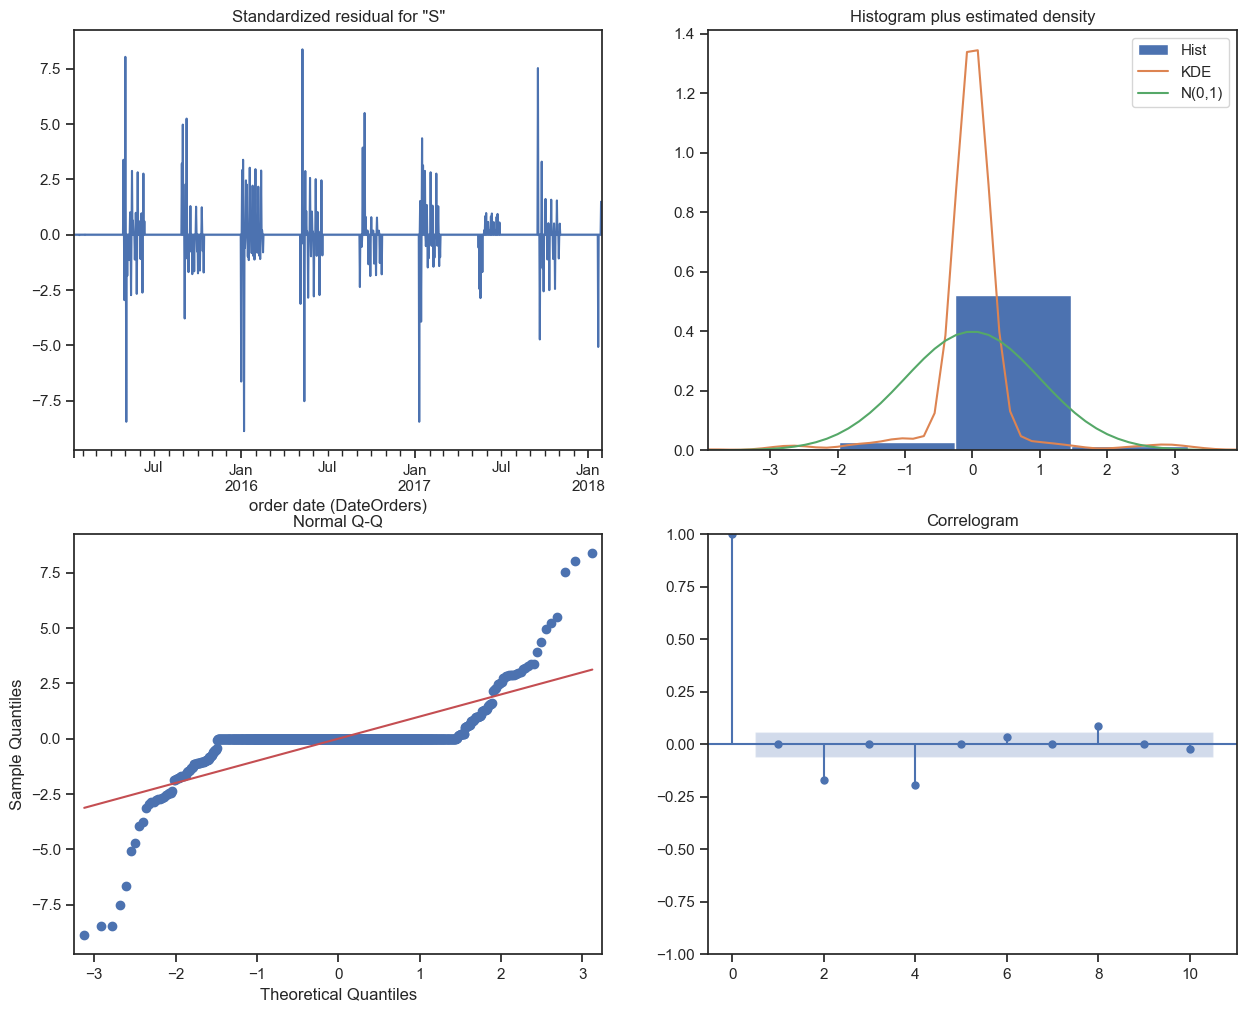

In [136]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit the best SARIMA model
model_Sales_BoxCox = sm.tsa.statespace.SARIMAX(df_timeseries_box_cox['Sales_BoxCox'], order=(0, 1, 0), seasonal_order=(2, 1, 0, 12))
results_Sales_BoxCox = model.fit()

# Plot the diagnostics
results_Sales_BoxCox.plot_diagnostics(figsize=(15, 12))
plt.show()



Now trying out Moving Average

In [137]:
# Sort the DataFrame by the date index to ensure monotonicity
df_timeseries_ma = df_timeseries_ma.sort_values('order date (DateOrders)')

# Set the date column as the index for time series analysis
df_timeseries_ma = df_timeseries_ma.set_index('order date (DateOrders)')

# Ensure the index is a DatetimeIndex and set a frequency

df_timeseries_ma = df_timeseries_ma.asfreq('d')
df_timeseries_ma = df_timeseries_ma.fillna(method='ffill')
df_timeseries_ma = df_timeseries_ma.fillna(method='bfill')


# Optionally check if any NaN remains
print(df_timeseries_ma.isna().sum())


Sales              0
Sales_MovingAvg    0
dtype: int64


C:\Users\CZ0068\AppData\Local\Temp\ipykernel_16468\2604202847.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_timeseries_ma = df_timeseries_ma.fillna(method='ffill')
C:\Users\CZ0068\AppData\Local\Temp\ipykernel_16468\2604202847.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_timeseries_ma = df_timeseries_ma.fillna(method='bfill')


In [138]:
df_timeseries_ma.shape

(1127, 2)

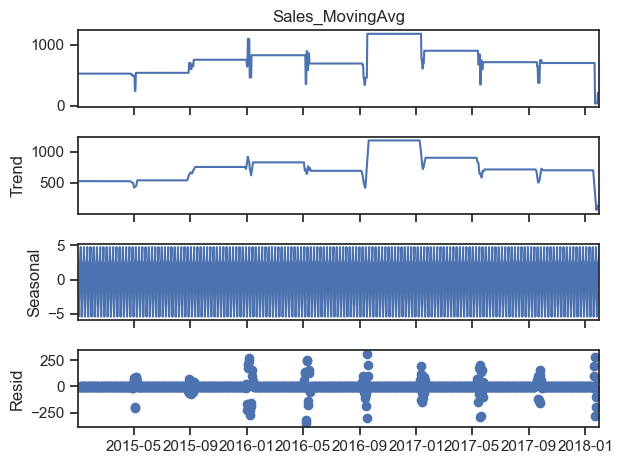

In [139]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_timeseries_ma['Sales_MovingAvg'], model='additive')
decomposition.plot()
plt.show()


In [140]:
from statsmodels.tsa.stattools import adfuller
test_result_ma = adfuller(df_timeseries_ma['Sales_MovingAvg'])
print('ADF Statistic:', test_result_ma[0])
print('p-value:', test_result_ma[1])

ADF Statistic: -2.0139826297054344
p-value: 0.2804760562808922


In [141]:
# First differencing
df_timeseries_ma['Sales_MovingAvg_diff'] = df_timeseries_ma['Sales_MovingAvg'].diff().dropna()

# Check stationarity again
result_diff_ma = adfuller(df_timeseries_ma['Sales_MovingAvg_diff'].dropna())
print('ADF Statistic:', result_diff_ma[0])
print('p-value:', result_diff_ma[1])

ADF Statistic: -15.800837872743266
p-value: 1.0745409334050848e-28


In [142]:
import pmdarima as pm

# Assuming the seasonal period is 12 (e.g., monthly data with yearly seasonality)
sarima_model_Sales_ma = pm.auto_arima(df_timeseries_ma['Sales_MovingAvg'], 
                             seasonal=True, m=12, 
                             d=1, D=1,   # non-seasonal and seasonal differencing
                             start_p=0, start_q=0, max_p=3, max_q=3,
                             start_P=0, start_Q=0, max_P=2, max_Q=2,
                             trace=True, error_action='ignore', 
                             suppress_warnings=True, stepwise=True)

print(sarima_model_Sales_ma.summary())



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12887.136, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12598.955, Time=0.88 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=12889.136, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12484.766, Time=3.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=86.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=12482.766, Time=2.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=12596.955, Time=0.81 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=49.48 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=12484.766, Time=3.86 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=63.49 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=12484.716, Time=47.52 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]

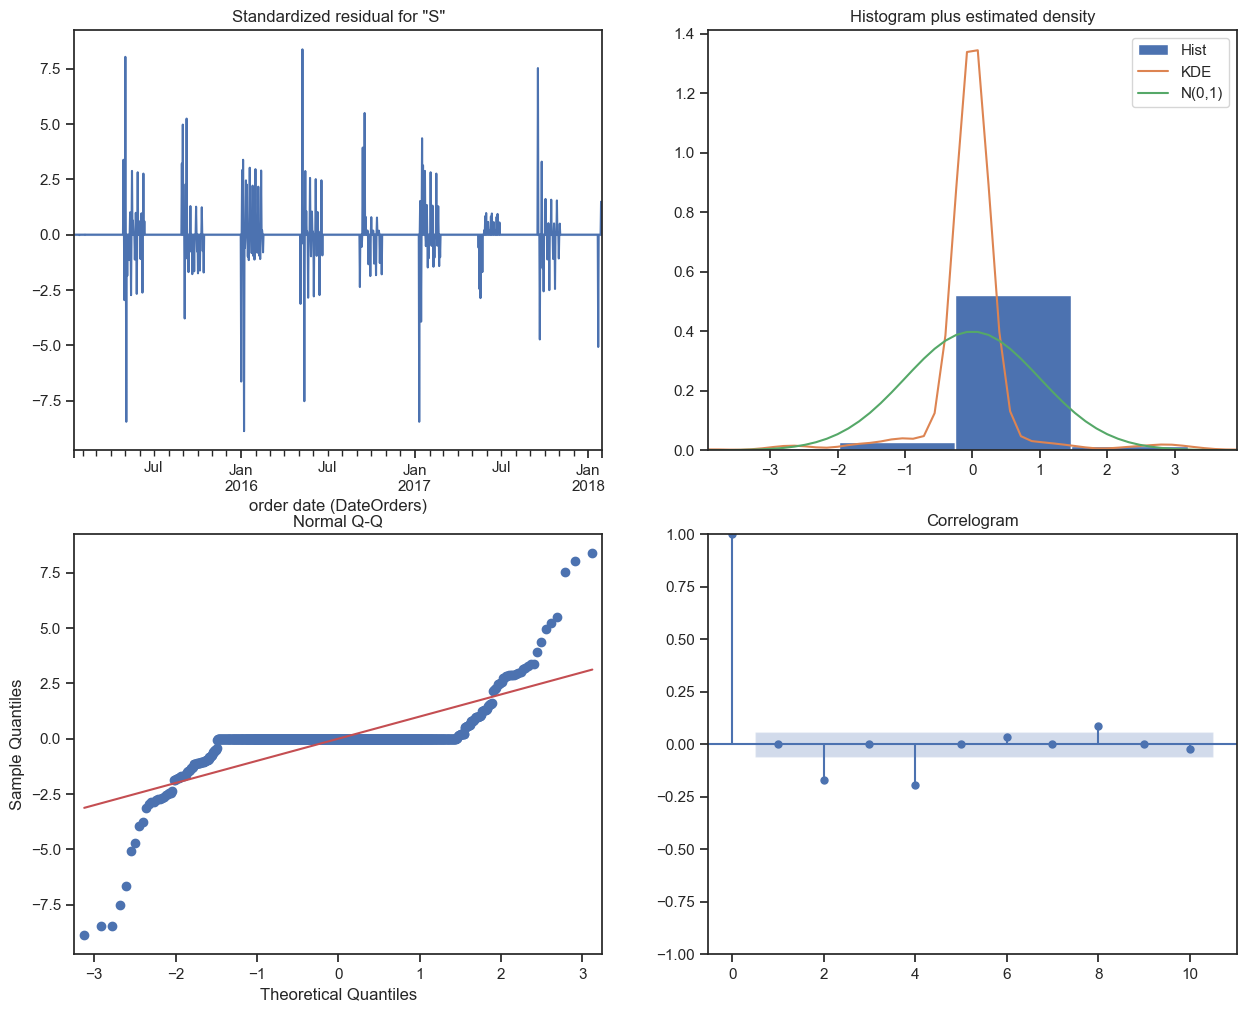

In [143]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit the best SARIMA model
model_Sales_ma = sm.tsa.statespace.SARIMAX(df_timeseries_ma['Sales_MovingAvg'], order=(0, 1, 0), seasonal_order=(2, 1, 0, 12))
results_ma = model.fit()

# Plot the diagnostics
results_ma.plot_diagnostics(figsize=(15, 12))
plt.show()

Given the strong performance in ADF statistics post-differencing and also other observations, trying SARIMA with  Log Sales and Box-Cox
 


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Box-Cox Transformation Errors:
MAE: 614.9607431162607, MSE: 378432.3930637376, RMSE: 615.1685891393819, MAPE: 3623.5769112629546%

Log Transformation Errors:
MAE: 634.2303354509268, MSE: 402249.30455238704, RMSE: 634.231270557032, MAPE: 14186.027374914753%


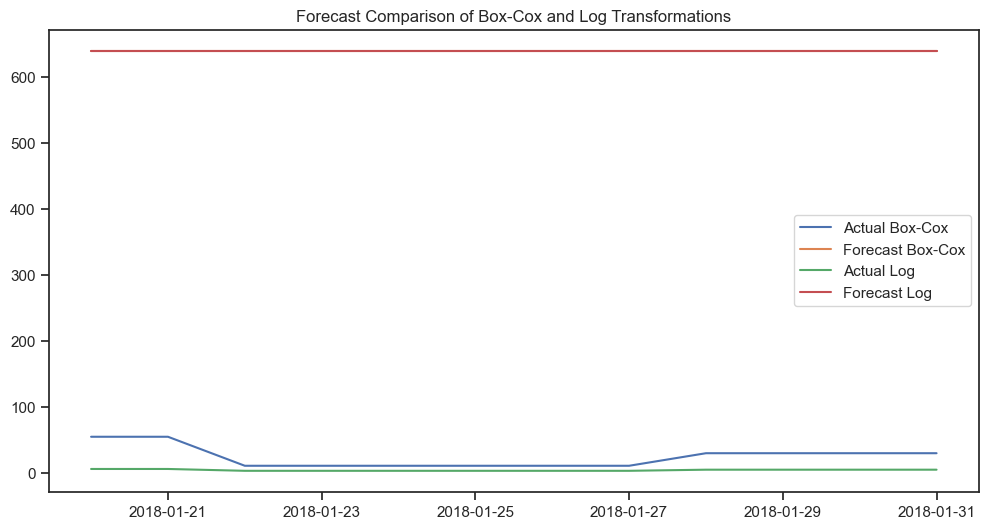

In [147]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Split data into train and test for both transformations
train_data_boxcox = df_timeseries_box_cox['Sales_BoxCox'][:-12]  # Holding out the last 12 months for testing
test_data_boxcox = df_timeseries_box_cox['Sales_BoxCox'][-12:]

train_data_log = aggregated_sales['Log_Sales'][:-12]
test_data_log = aggregated_sales['Log_Sales'][-12:]


# Fit SARIMA function defined as before
def fit_sarima(data, seasonal_order=(2, 1, 0, 12)):
    model = SARIMAX(data, order=(0, 1, 0), seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    return results

# Fit models
results_boxcox = fit_sarima(train_data_boxcox)
results_log = fit_sarima(train_data_log)

# Forecasting
forecast_boxcox = results_boxcox.get_forecast(steps=12)
forecast_log = results_log.get_forecast(steps=12)

# Actual test data for error calculation
actual_boxcox = test_data_boxcox
actual_log = test_data_log

# Inverse transformation to original scale
# Lambda for Box-Cox and adding 1 for the log transformation might need to be adjusted
lambda_boxcox= 0.5270136564457502
forecast_boxcox_values = np.exp(np.log(forecast_boxcox.predicted_mean * lambda_boxcox + 1) / lambda_boxcox)
forecast_log_values = np.exp(forecast_log.predicted_mean) - 1

# Calculate errors
def calculate_errors(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, mse, rmse, mape

mae_boxcox, mse_boxcox, rmse_boxcox, mape_boxcox = calculate_errors(actual_boxcox, forecast_boxcox_values)
mae_log, mse_log, rmse_log, mape_log = calculate_errors(actual_log, forecast_log_values)

# Display the errors
print("Box-Cox Transformation Errors:")
print(f"MAE: {mae_boxcox}, MSE: {mse_boxcox}, RMSE: {rmse_boxcox}, MAPE: {mape_boxcox}%")

print("\nLog Transformation Errors:")
print(f"MAE: {mae_log}, MSE: {mse_log}, RMSE: {rmse_log}, MAPE: {mape_log}%")

# Optionally, display plots to compare visually
plt.figure(figsize=(12, 6))
plt.plot(actual_boxcox.index, actual_boxcox, label='Actual Box-Cox')
plt.plot(actual_boxcox.index, forecast_boxcox_values, label='Forecast Box-Cox')
plt.plot(actual_log.index, actual_log, label='Actual Log')
plt.plot(actual_log.index, forecast_log_values, label='Forecast Log')
plt.title('Forecast Comparison of Box-Cox and Log Transformations')
plt.legend()
plt.show()


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Box-Cox Transformation Errors:
MAE: 614.9607431162607, MSE: 378432.3930637376, RMSE: 615.1685891393819, MAPE: 3623.5769112629546%

Log Transformation Errors:
MAE: 634.2303354509268, MSE: 402249.30455238704, RMSE: 634.231270557032, MAPE: 14186.027374914753%


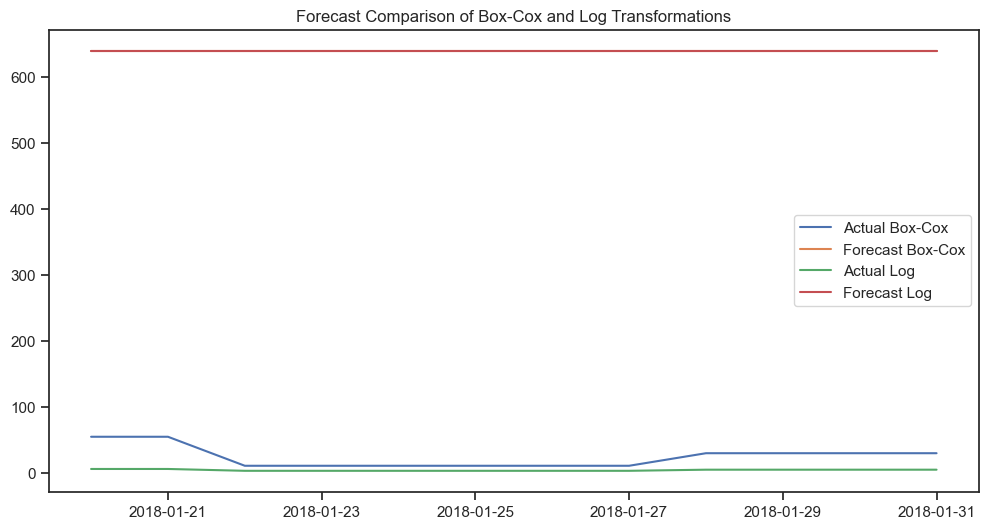

In [149]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the SARIMA fitting function with adjustments
def fit_sarima(data, seasonal_order=(2, 1, 0, 12), maxiter=500, method='nm', tol=1e-4):
    model = SARIMAX(data, order=(0, 1, 0), seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    try:
        results = model.fit(disp=False, maxiter=maxiter, method=method, tol=tol)
    except ValueError as e:
        print(f"Model fitting failed: {e}")
        return None
    except np.linalg.LinAlgError:
        print("Model fitting encountered a linear algebra error.")
        return None
    return results

# Fit models with adjusted settings
results_boxcox = fit_sarima(train_data_boxcox)
results_log = fit_sarima(train_data_log)

if results_boxcox is None or results_log is None:
    print("Model fitting was unsuccessful.")
else:
    # Forecasting
    forecast_boxcox = results_boxcox.get_forecast(steps=12)
    forecast_log = results_log.get_forecast(steps=12)

    # Inverse transformation to original scale
    lambda_boxcox = 0.5270136564457502  # This should be the lambda used during the Box-Cox transformation
    forecast_boxcox_values = np.exp(np.log(forecast_boxcox.predicted_mean * lambda_boxcox + 1) / lambda_boxcox)
    forecast_log_values = np.exp(forecast_log.predicted_mean) - 1

    # Calculate errors
    def calculate_errors(actual, forecast):
        mae = mean_absolute_error(actual, forecast)
        mse = mean_squared_error(actual, forecast)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual - forecast) / actual)) * 100
        return mae, mse, rmse, mape

    mae_boxcox, mse_boxcox, rmse_boxcox, mape_boxcox = calculate_errors(test_data_boxcox, forecast_boxcox_values)
    mae_log, mse_log, rmse_log, mape_log = calculate_errors(test_data_log, forecast_log_values)

    # Display the errors
    print("Box-Cox Transformation Errors:")
    print(f"MAE: {mae_boxcox}, MSE: {mse_boxcox}, RMSE: {rmse_boxcox}, MAPE: {mape_boxcox}%")

    print("\nLog Transformation Errors:")
    print(f"MAE: {mae_log}, MSE: {mse_log}, RMSE: {rmse_log}, MAPE: {mape_log}%")

    # Optionally, display plots to compare visually
    plt.figure(figsize=(12, 6))
    plt.plot(test_data_boxcox.index, test_data_boxcox, label='Actual Box-Cox')
    plt.plot(test_data_boxcox.index, forecast_boxcox_values, label='Forecast Box-Cox')
    plt.plot(test_data_log.index, test_data_log, label='Actual Log')
    plt.plot(test_data_log.index, forecast_log_values, label='Forecast Log')
    plt.title('Forecast Comparison of Box-Cox and Log Transformations')
    plt.legend()
    plt.show()


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Box-Cox Transformation Errors:
MAE: 614.9607431162607, MSE: 378432.3930637376, RMSE: 615.1685891393819, MAPE: 3623.5769112629546%

Log Transformation Errors:
MAE: 634.2303354509268, MSE: 402249.30455238704, RMSE: 634.231270557032, MAPE: 14186.027374914753%


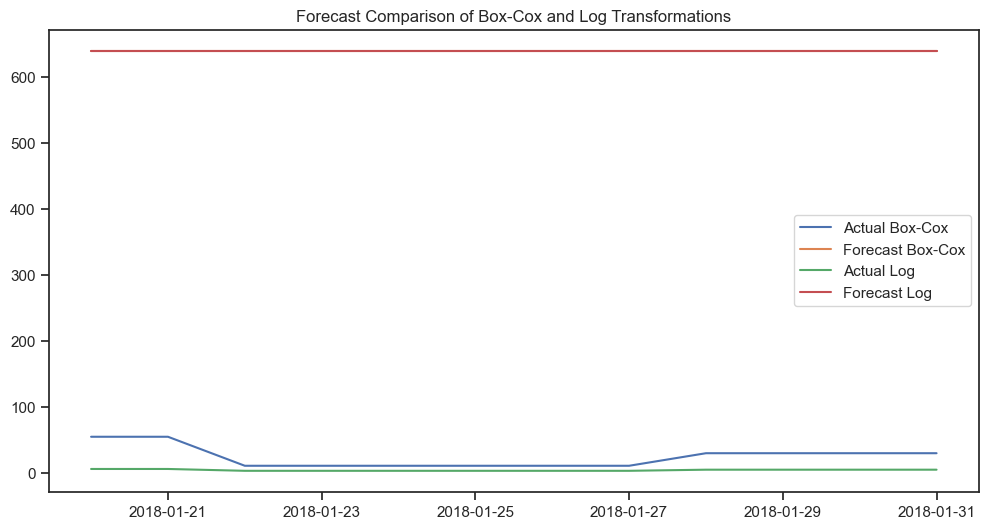

In [150]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the SARIMA fitting function with adjustments
def fit_sarima(data, seasonal_order=(2, 1, 0, 12), maxiter=500, method='bfgs', tol=1e-4):
    model = SARIMAX(data, order=(0, 1, 0), seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    try:
        results = model.fit(disp=False, maxiter=maxiter, method=method, tol=tol)
    except ValueError as e:
        print(f"Model fitting failed: {e}")
        return None
    except np.linalg.LinAlgError:
        print("Model fitting encountered a linear algebra error.")
        return None
    return results

# Fit models with adjusted settings
results_boxcox = fit_sarima(train_data_boxcox)
results_log = fit_sarima(train_data_log)

if results_boxcox is None or results_log is None:
    print("Model fitting was unsuccessful.")
else:
    # Forecasting
    forecast_boxcox = results_boxcox.get_forecast(steps=12)
    forecast_log = results_log.get_forecast(steps=12)

    # Inverse transformation to original scale
    lambda_boxcox = 0.5270136564457502  # This should be the lambda used during the Box-Cox transformation
    forecast_boxcox_values = np.exp(np.log(forecast_boxcox.predicted_mean * lambda_boxcox + 1) / lambda_boxcox)
    forecast_log_values = np.exp(forecast_log.predicted_mean) - 1

    # Calculate errors
    def calculate_errors(actual, forecast):
        mae = mean_absolute_error(actual, forecast)
        mse = mean_squared_error(actual, forecast)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual - forecast) / actual)) * 100
        return mae, mse, rmse, mape

    mae_boxcox, mse_boxcox, rmse_boxcox, mape_boxcox = calculate_errors(test_data_boxcox, forecast_boxcox_values)
    mae_log, mse_log, rmse_log, mape_log = calculate_errors(test_data_log, forecast_log_values)

    # Display the errors
    print("Box-Cox Transformation Errors:")
    print(f"MAE: {mae_boxcox}, MSE: {mse_boxcox}, RMSE: {rmse_boxcox}, MAPE: {mape_boxcox}%")

    print("\nLog Transformation Errors:")
    print(f"MAE: {mae_log}, MSE: {mse_log}, RMSE: {rmse_log}, MAPE: {mape_log}%")

    # Optionally, display plots to compare visually
    plt.figure(figsize=(12, 6))
    plt.plot(test_data_boxcox.index, test_data_boxcox, label='Actual Box-Cox')
    plt.plot(test_data_boxcox.index, forecast_boxcox_values, label='Forecast Box-Cox')
    plt.plot(test_data_log.index, test_data_log, label='Actual Log')
    plt.plot(test_data_log.index, forecast_log_values, label='Forecast Log')
    plt.title('Forecast Comparison of Box-Cox and Log Transformations')
    plt.legend()
    plt.show()


In [151]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Split data into train and test sets for both transformations
train_data_boxcox = df_timeseries_box_cox['Sales_BoxCox'][:-12]  # Last 12 data points for testing
test_data_boxcox = df_timeseries_box_cox['Sales_BoxCox'][-12:]

train_data_log = aggregated_sales['Log_Sales'][:-12]
test_data_log = aggregated_sales['Log_Sales'][-12:]

# Define the available optimization methods
optimizers = ['lbfgs', 'bfgs', 'powell', 'cg', 'ncg', 'basinhopping']

# Results storage
results_storage = {}

# Loop over each optimizer
for optimizer in optimizers:
    print(f"\nFitting SARIMA models using optimizer: {optimizer}")
    try:
        # Define SARIMA fitting function
        def fit_sarima(data, seasonal_order=(2, 1, 0, 12), maxiter=500, method=optimizer, tol=1e-4):
            model = SARIMAX(data, order=(0, 1, 0), seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False, maxiter=maxiter, method=method, tol=tol)
            return results

        # Fit models
        results_boxcox = fit_sarima(train_data_boxcox)
        results_log = fit_sarima(train_data_log)

        # Forecasting
        forecast_boxcox = results_boxcox.get_forecast(steps=12)
        forecast_log = results_log.get_forecast(steps=12)

        # Inverse transformation to original scale
        lambda_boxcox = 0.5270136564457502  # This is the lambda used during the Box-Cox transformation
        forecast_boxcox_values = np.exp(np.log(forecast_boxcox.predicted_mean * lambda_boxcox + 1) / lambda_boxcox)
        forecast_log_values = np.exp(forecast_log.predicted_mean) - 1

        # Calculate errors
        def calculate_errors(actual, forecast):
            mae = mean_absolute_error(actual, forecast)
            mse = mean_squared_error(actual, forecast)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual - forecast) / actual)) * 100
            return mae, mse, rmse, mape

        mae_boxcox, mse_boxcox, rmse_boxcox, mape_boxcox = calculate_errors(test_data_boxcox, forecast_boxcox_values)
        mae_log, mse_log, rmse_log, mape_log = calculate_errors(test_data_log, forecast_log_values)

        # Store results
        results_storage[optimizer] = {
            'boxcox': (mae_boxcox, mse_boxcox, rmse_boxcox, mape_boxcox),
            'log': (mae_log, mse_log, rmse_log, mape_log)
        }

        # Display the errors
        print(f"Optimizer: {optimizer} - Box-Cox Transformation Errors:")
        print(f"MAE: {mae_boxcox}, MSE: {mse_boxcox}, RMSE: {rmse_boxcox}, MAPE: {mape_boxcox}%")

        print(f"\nOptimizer: {optimizer} - Log Transformation Errors:")
        print(f"MAE: {mae_log}, MSE: {mse_log}, RMSE: {rmse_log}, MAPE: {mape_log}%")

    except Exception as e:
        print(f"Model fitting failed with optimizer {optimizer}: {e}")

# Plotting comparison for the best optimizer based on one of the metrics (e.g., RMSE)
best_optimizer_boxcox = min(results_storage, key=lambda k: results_storage[k]['boxcox'][2])
best_optimizer_log = min(results_storage, key=lambda k: results_storage[k]['log'][2])

print(f"\nBest optimizer for Box-Cox based on RMSE: {best_optimizer_boxcox}")
print(f"Best optimizer for Log based on RMSE: {best_optimizer_log}")

# Optionally plot results from the best optimizer
def plot_forecast(actual, forecast, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, forecast, label='Forecast')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot for best optimizer for Box-Cox
forecast_boxcox_best = fit_sarima(train_data_boxcox, method=best_optimizer_boxcox).get_forecast(steps=12)
forecast_boxcox_best_values = np.exp(np.log(forecast_boxcox_best.predicted_mean * lambda_boxcox + 1) / lambda_boxcox)
plot_forecast(test_data_boxcox, forecast_boxcox_best_values, f'Box-Cox Forecast with {best_optimizer_boxcox}')

# Plot for best optimizer for Log
forecast_log_best = fit_sarima(train_data_log, method=best_optimizer_log).get_forecast(steps=12)
forecast_log_best_values = np.exp(forecast_log_best.predicted_mean) - 1
plot_forecast(test_data_log, forecast_log_best_values, f'Log Forecast with {best_optimizer_log}')



Fitting SARIMA models using optimizer: lbfgs


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\m

Optimizer: lbfgs - Box-Cox Transformation Errors:
MAE: 614.9607431162607, MSE: 378432.3930637376, RMSE: 615.1685891393819, MAPE: 3623.5769112629546%

Optimizer: lbfgs - Log Transformation Errors:
MAE: 634.2303354509268, MSE: 402249.30455238704, RMSE: 634.231270557032, MAPE: 14186.027374914753%

Fitting SARIMA models using optimizer: bfgs


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Optimizer: bfgs - Box-Cox Transformation Errors:
MAE: 614.9607431162607, MSE: 378432.3930637376, RMSE: 615.1685891393819, MAPE: 3623.5769112629546%

Optimizer: bfgs - Log Transformation Errors:
MAE: 634.2303354509268, MSE: 402249.30455238704, RMSE: 634.231270557032, MAPE: 14186.027374914753%

Fitting SARIMA models using optimizer: powell


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Optimizer: powell - Box-Cox Transformation Errors:
MAE: 614.9607431162607, MSE: 378432.3930637376, RMSE: 615.1685891393819, MAPE: 3623.5769112629546%

Optimizer: powell - Log Transformation Errors:
MAE: 634.2303354509268, MSE: 402249.30455238704, RMSE: 634.231270557032, MAPE: 14186.027374914753%

Fitting SARIMA models using optimizer: cg


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method cg is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method cg is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Optimizer: cg - Box-Cox Transformation Errors:
MAE: 614.9607431162607, MSE: 378432.3930637376, RMSE: 615.1685891393819, MAPE: 3623.5769112629546%

Optimizer: cg - Log Transformation Errors:
MAE: 634.2303354509268, MSE: 402249.30455238704, RMSE: 634.231270557032, MAPE: 14186.027374914753%

Fitting SARIMA models using optimizer: ncg


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method ncg is: fhess_p, avextol, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Model fitting failed with optimizer ncg: Cannot use complex-step approximations to calculate the hessian with untransformed parameters.

Fitting SARIMA models using optimizer: basinhopping


c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method basinhopping is: niter, niter_success, T, stepsize, interval, minimizer, seed. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\CZ0068\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method basinhopping is: niter, niter_success, T, stepsize, interval, minimizer, seed. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Have tried different options with different settings. SARIMA is not able to do the correct forecasting for both cases. Hence dropping it. We already have very good results with Linear Models and Tree based models.